In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.special import rel_entr
from scipy.stats import gamma
import json
import sys
from statistics import median

def margin(a):
    b = a
    for i in range(len(a)):
        if a[i] == 0:
            b[i] = 10**(-5)
    return b

In [76]:
def read_AQUA_file(filename):
    AQUA_file = open(filename, "r")
    AQUA_data = json.load(AQUA_file)
    res = AQUA_data['data']

    plt.plot(res[0], res[1])
    print(min(res[0]), max(res[0]))

    AQUA_mean = (sum(np.multiply(res[0], res[1])))
    AQUA_variance = sum(np.multiply(np.square(res[0]), res[1])) - AQUA_mean**2

    return AQUA_mean, AQUA_variance

def gt_from_sampling(filename, var_list):
    mean_list = {}
    variance_list = {}
    gt_file = open(filename, "r")
    gt_lines = gt_file.readlines()
    for var_name in var_list:
        for i in gt_lines:
            j = i.split(' ')
            if j[0] == var_name:
                j_temp = []
                for k in j:
                    if k != "":
                        j_temp.append(k)
                mean_list[var_name] = float(j_temp[1])
                variance_list[var_name] = float(j_temp[3])**2
    return mean_list, variance_list


def read_AQUA_time(filename):
    a = open(filename, "r")
    data = a.readlines()
    time = []
    for i in data:
        if i[0:8] == "Analysis":
            time.append(float(i.split(',')[-1])*1000)
    return (median(time))

colors = ['blue', 'green', 'purple', 'yellow', 'black', 'red', 'brown', 'pink', 'gray', 'olive', 'cyan', 'violet', 'coral']
AQUA_color = 'orange'

def plotting_dice_data(mean_or_var, title, var_name, result_file, 
                        lowerlimit, upperlimit, offset, gt, AQUA_time, 
                            AQUA_val, annot, s_or_ms, ylab = None, AQUA_plot = None):
    fig, ax = plt.subplots()
    if ylab == None:
        ax.set_ylabel('Absolute Error of ' + mean_or_var)
    else:
        ax.set_ylabel(ylab)
    ax.set_xscale("log")
    ax.set_xlabel('Time(in ms)')
    ax.set_yscale("log")
    ax.set_title(title + " - " + var_name)

    fig.set_facecolor('white')
    fig.set_size_inches(13.5, 9)
    legend = []

    index = 0
    if mean_or_var == 'variance':
        index = 2

    data = open(result_file, "r")
    data_lines = data.readlines()

    print (data_lines)
    min_res = []

    for no in range(lowerlimit, upperlimit):
        dice = [(float(j.split(',')[1]), j) for j in data_lines if float(j.split(',')[0]) == no]
        dice.sort()

        dice = [j[1] for j in dice]

        t = []
        abs_err = []
        time = []


        for j in range(len(dice)):
            temp = dice[j].split(',')
            t.append((temp[0], temp[1], temp[3]))

            print(temp[5 + index], gt)
            temp2 = abs(float(temp[5 + index]) + (offset)*1/2**(no) - gt)
            print(temp2)
            abs_err.append(temp2)

            temp3 = float(temp[4 + index])
            if s_or_ms == 's':
                temp3 = temp3*1000
            time.append(temp3)
        # print (abs_err)

        ax.plot(time, abs_err, '-o', color= colors[no])
        print(time, abs_err)

        if annot:
            for i in range(len(t)):
                ax.annotate(t[i], (time[i], abs_err[i]))

        legend.append("BitBlast " + str(no))
        min_res.append(min(abs_err))
        

    AQUA_pt = (AQUA_time, abs(AQUA_val - gt))
    if AQUA_plot == None:
        ax.scatter(AQUA_pt[0], AQUA_pt[1], color = AQUA_color)
        ax.annotate('AQUA', AQUA_pt)


    ax.legend(legend + ["AQUA"])
    if mean_or_var == "mean":
        bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_expectation.csv", "a")
        bpfile.write(title + ", " + var_name + ", " + str(min(min_res)) + ", " + str(AQUA_pt[1]) + "\n")
        bpfile.close()
    else:
        bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
        bpfile.write(title + ", " + var_name + ", " + str(min(min_res)) + ", " + str(AQUA_pt[1]) + "\n")
        bpfile.close()

    print(min(min_res), (AQUA_pt[1]))

    fig.savefig("/home/poorvagarg/.julia/dev/Dice/benchmarks/" + title + "/"+title + "_" + var_name + "_" + mean_or_var + ".png")
    return fig, ax

def plotting_dice_bits(mean_or_var, title, var_name, result_file, 
                        lowerlimit, upperlimit, offset, gt, AQUA_time, 
                            AQUA_val, annot, s_or_ms, ylab = None, AQUA_plot = None):
    fig, ax = plt.subplots()
    if ylab == None:
        ax.set_ylabel('Absolute Error of ' + mean_or_var)
    else:
        ax.set_ylabel(ylab)
    ax.set_xscale("log")
    ax.set_xlabel('Time(in ms)')
    ax.set_yscale("log")
    ax.set_title(title + " - " + var_name)

    fig.set_facecolor('white')
    fig.set_size_inches(13.5, 9)
    legend = []

    index = 0
    if mean_or_var == 'variance':
        index = 2

    data = open(result_file, "r")
    data_lines = data.readlines()

    print (data_lines)

    for no in range(lowerlimit, upperlimit):
        dice = [(float(j.split(',')[0]), j) for j in data_lines if float(j.split(',')[1]) == no]
        dice.sort()

        dice = [j[1] for j in dice]

        t = []
        abs_err = []
        time = []


        for j in range(len(dice)):
            temp = dice[j].split(',')
            t.append((temp[0], temp[1], temp[3]))

            print(temp[index+5], gt)
            temp2 = abs(float(temp[5 + index]) + (offset)*1/2**(float(temp[0])) - gt)
            print(temp2)
            abs_err.append(temp2)

            temp3 = float(temp[4 + index])
            if s_or_ms == 's':
                temp3 = temp3*1000
            time.append(temp3)
        # print (abs_err)

        ax.plot(time, abs_err, '-o', color= colors[no])
        print(time, abs_err)

        if annot:
            for i in range(len(t)):
                ax.annotate(t[i], (time[i], abs_err[i]))

        legend.append("BitBlast " + str(no))

    AQUA_pt = (AQUA_time, abs(AQUA_val - gt))
    if AQUA_plot == None:
        ax.scatter(AQUA_pt[0], AQUA_pt[1], color = AQUA_color)
        ax.annotate('AQUA', AQUA_pt)


    ax.legend(legend + ["AQUA"])

    fig.savefig("/home/poorvagarg/.julia/dev/Dice/benchmarks/" + title + "/"+title + "_" + var_name + "_" + mean_or_var + ".png")
    return fig, ax
    

In [4]:
a = open("/home/poorvagarg/.julia/dev/Dice/tow_acc.txt", "r")
b = open("/home/poorvagarg/.julia/dev/Dice/tow_bdd.txt", "r")
time_data = open("/home/poorvagarg/.julia/dev/Dice/tow_timw.txt", "r")
acc = a.readlines()
bdd = b.readlines()
runtime = time_data.readlines()

0.00011848338264708325


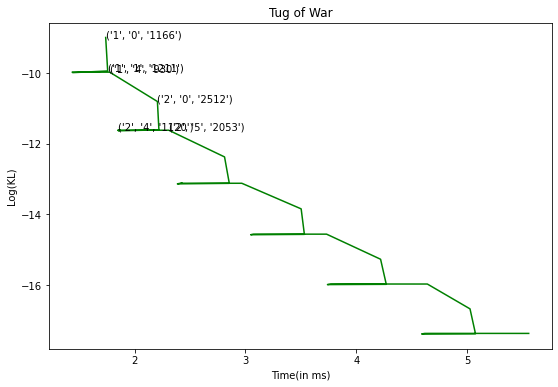

In [4]:
y = [math.log(sum(rel_entr([0.5, 0.5], [float(j.split(',')[2]), 1 - float(j.split(',')[2])]))) for j in acc]
x = [math.log(float(j.split('(')[1][:-4])) for j in runtime]

x2 = [abs(float(j.split(',')[2]) - 0.5) for j in acc]
print(min(x2))


tic = [(j.split(',')[0], j.split(',')[1], j.split(',')[3][:-1]) for j in bdd]

fig1, ax1 = plt.subplots()

ax1.plot(x, y, color= "green")
ax1.set_ylabel('Log(KL)')
ax1.set_xlabel('Time(in ms)')
ax1.set_title("Tug of War")
for i in [0, 1, 4, 5, 9, 10]:
    ax1.annotate(tic[i], (x[i], y[i]))
fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)

<ipython-input-5-6ff49ab47dd6>:14: RuntimeWarning: invalid value encountered in double_scalars
  y = [math.log(sum(rel_entr([0.5, 0.5], [float(j.split(' ')[1]), 1 - float(j.split(' ')[1])]))) for j in mcmc]


7


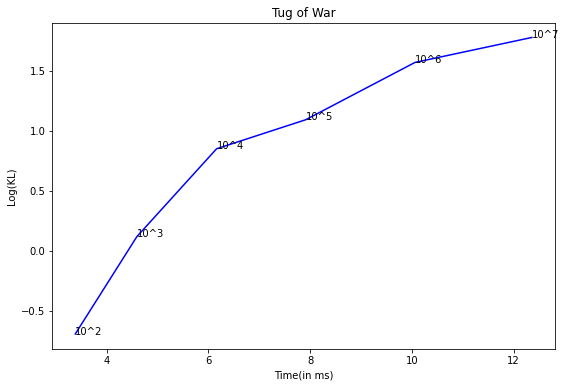

In [5]:
c = open("/home/poorvagarg/.julia/dev/Dice/tow_mcmc.txt", "r")
mcmc = c.readlines()
# mcmc = mcmc]

fig1, ax1 = plt.subplots()

ax1.set_ylabel('Log(KL)')
ax1.set_xlabel('Time(in ms)')
ax1.set_title("Tug of War")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)

y = [math.log(sum(rel_entr([0.5, 0.5], [float(j.split(' ')[1]), 1 - float(j.split(' ')[1])]))) for j in mcmc]
x = [math.log(float(j.split(' ')[0])) for j in mcmc]

print(len(x))

t = [str(10) + "^" + str(i) for i in range(1, 8)]

ax1.plot(x, y, color= "blue")
for i in range(len(t)):
    ax1.annotate(t[i], (x[i], y[i]))



[5.499215308914927, 7.113142108707088, 9.345439285397797, 11.58042989594566, 13.830672532106103, 16.18252554119577, 18.498661644484688]


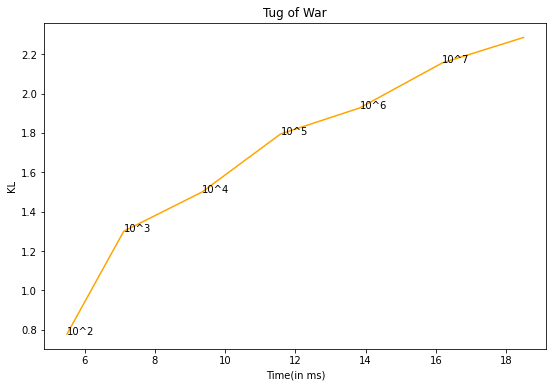

In [6]:
d = open("/home/poorvagarg/.julia/dev/Dice/tow_rej.txt", "r")
rej = d.readlines()
rej = rej[1:]

fig1, ax1 = plt.subplots()

ax1.set_ylabel('KL')
ax1.set_xlabel('Time(in ms)')
ax1.set_title("Tug of War")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)

y = [math.log(sum(rel_entr([0.5, 0.5], [float(j.split(' ')[1]), 1 - float(j.split(' ')[1])]))) for j in rej]
x = [math.log(float(j.split(' ')[0])) for j in rej]

print(x)

t = [str(10) + "^" + str(i) for i in range(2, 8)]

ax1.plot(x, y, color= "orange")
for i in range(len(t)):
    ax1.annotate(t[i], (x[i], y[i]))

['22.0 inf nan\n', '29.5 0.10263197561265668 0.4387307114576635\n', '99.0 0.027082416365937674 0.11245187152444017\n', '474.0 0.0023216302393432656 0.005076798885775345\n', '2724.5 0.0006442101020790987 0.0012488747462098986\n', '23394.0 1.658048924769442e-05 4.331232563473445e-05\n', '232246.5 1.7886810419223643e-06 7.16560508941726e-06']
7
[244.5, 1228.0, 11446.5, 106983.5, 1015277.5, 10665508.0, 108110201.0]


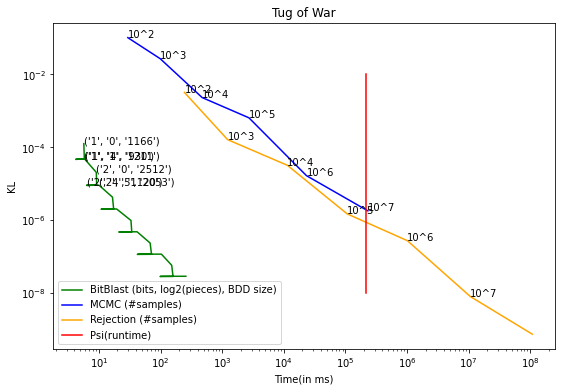

In [7]:
y = [(sum(rel_entr([0.5, 0.5], [float(j.split(',')[2]), 1 - float(j.split(',')[2])]))) for j in acc]
x = [(float(j.split('(')[1][:-4])) for j in runtime]


tic = [(j.split(',')[0], j.split(',')[1], j.split(',')[3][:-1]) for j in bdd]

fig1, ax1 = plt.subplots()

ax1.plot(x, y, color= "green")
ax1.set_ylabel('KL')
ax1.set_xlabel('Time(in ms)')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Tug of War")
for i in [0, 1, 4, 5, 9, 10]:
    ax1.annotate(tic[i], (x[i], y[i]))
fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)

print(mcmc)
y = [(float(j.split(' ')[1])) for j in mcmc]
x = [(float(j.split(' ')[0])) for j in mcmc]

print(len(x))

t = [str(10) + "^" + str(i) for i in range(1, 8)]

ax1.plot(x, y, color= "blue")
for i in range(len(t)):
    ax1.annotate(t[i], (x[i], y[i]))

y = [(float(j.split(' ')[1])) for j in rej]
x = [(float(j.split(' ')[0])) for j in rej]

print(x)

t = [str(10) + "^" + str(i) for i in range(2, 8)]

ax1.plot(x, y, color= "orange")
for i in range(len(t)):
    ax1.annotate(t[i], (x[i], y[i]))

ax1.plot([213305.5, (213305.5)], [10**(-2), 10**(-8)], color="red")

ax1.legend(["BitBlast (bits, log2(pieces), BDD size)", "MCMC (#samples)", "Rejection (#samples)", "Psi(runtime)"])

fig1.savefig("tow.png")

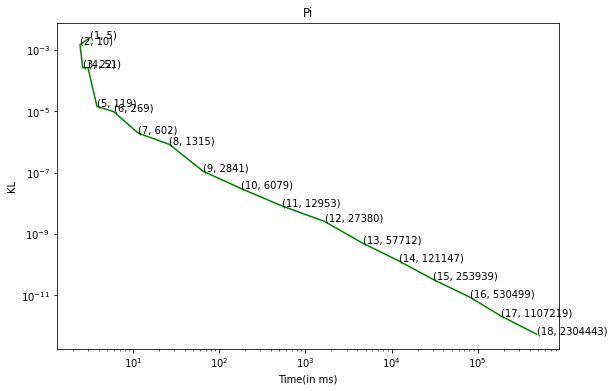

In [8]:
a = open("/home/poorvagarg/.julia/dev/Dice/pi_results.txt", "r")
pi_julia_acc = a.readlines()
# pi_julia_acc = pi_julia_acc[0:15]

# pi_julia_accuracy = readdlm("/home/poorvagarg/.julia/dev/Dice/pi_results.txt", ',', Float64, '\n')
pi_julia_bdd = [5, 10, 22, 51
, 119
, 269
,602
,1315
,2841
,6079
,12953
,27380
,57712
,121147
,253939
,530499
,1107219
,2304443]


t = [i for i in range(1, 19)]
pi_kld = [(float(j.split(',')[2])) for j in pi_julia_acc]
pi_time = [(float(j.split(',')[3])) for j in pi_julia_acc]
tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]

fig1, ax1 = plt.subplots()

ax1.plot(pi_time, pi_kld, color= "green")
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Pi")
for i in range(len(tic)):
    ax1.annotate(tic[i], (pi_time[i], pi_kld[i]))

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)



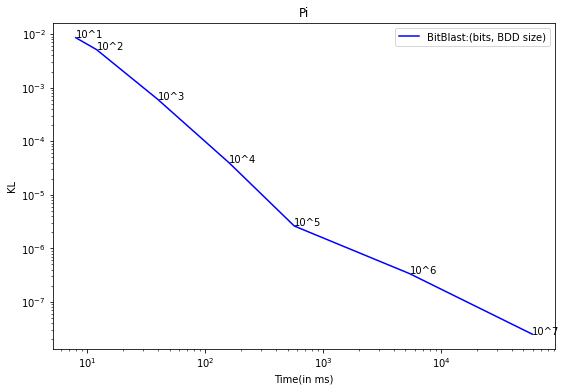

In [9]:
a = open("/home/poorvagarg/.julia/dev/Dice/pi_sample.txt", "r")
pi_acc = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Pi")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = [str(10) + "^" + str(i) for i in range(1, 8)]
pi_kld = [float(j.split(' ')[1]) for j in pi_acc]
pi_time = [float(j.split(' ')[0]) for j in pi_acc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]

ax1.plot(pi_time, pi_kld, color= "blue")
ax1.legend(["BitBlast:(bits, BDD size)", "Sampling"])

for i in range(len(t)):
    ax1.annotate(t[i], (pi_time[i], pi_kld[i]))
fig1.savefig("pi.png")

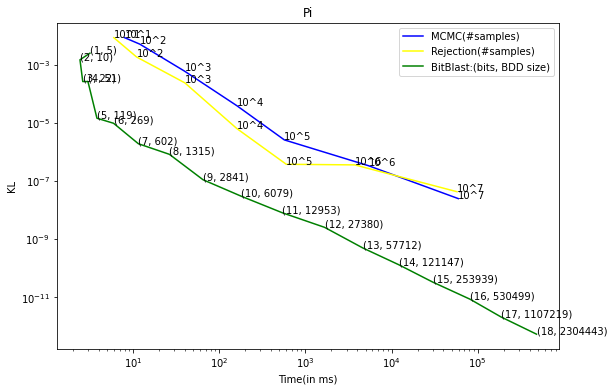

In [10]:
a = open("/home/poorvagarg/.julia/dev/Dice/pi_sample.txt", "r")
pi_acc = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Pi")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = [str(10) + "^" + str(i) for i in range(1, 8)]
pi_kld = [float(j.split(' ')[1]) for j in pi_acc]
pi_time = [float(j.split(' ')[0]) for j in pi_acc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]

ax1.plot(pi_time, pi_kld, color= "blue")

for i in range(len(t)):
    ax1.annotate(t[i], (pi_time[i], pi_kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/pi_rejection.txt", "r")
pi_acc = a.readlines()

t = [str(10) + "^" + str(i) for i in range(1, 8)]
pi_kld = [float(j.split(' ')[1]) for j in pi_acc]
pi_time = [float(j.split(' ')[0]) for j in pi_acc]

ax1.plot(pi_time, pi_kld, color= "yellow")
# ax1.legend(["BitBlast:(bits, BDD size)", "Sampling"])

for i in range(len(t)):
    ax1.annotate(t[i], (pi_time[i], pi_kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/pi_results.txt", "r")
pi_julia_acc = a.readlines()
# pi_julia_acc = pi_julia_acc[0:15]

# pi_julia_accuracy = readdlm("/home/poorvagarg/.julia/dev/Dice/pi_results.txt", ',', Float64, '\n')
pi_julia_bdd = [5, 10, 22, 51
, 119
, 269
,602
,1315
,2841
,6079
,12953
,27380
,57712
,121147
,253939
,530499
,1107219
,2304443]


t = [i for i in range(1, 19)]
pi_kld = [(float(j.split(',')[2])) for j in pi_julia_acc]
pi_time = [(float(j.split(',')[3])) for j in pi_julia_acc]
tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]
ax1.plot(pi_time, pi_kld, color= "green")
for i in range(len(tic)):
    ax1.annotate(tic[i], (pi_time[i], pi_kld[i]))

ax1.legend(["MCMC(#samples)", "Rejection(#samples)", "BitBlast:(bits, BDD size)"])
fig1.savefig("pi.png")

['0.0', '1', '0', '27', '53', '0.16658619011506628', 'TrialEstimate(3.603 ms)\n', '3.603']
['0.0,1,1,19,38,0.6094160643256045,TrialEstimate(2.913 ms)\n,2.913', '0.0,2,2,21,41,0.6114580225852986,TrialEstimate(3.768 ms)\n,3.768', '0.0,3,1,27,50,0.6115084233728768,TrialEstimate(3.495 ms)\n,3.495', '0.0,4,0,33,59,0.45845272261044445,TrialEstimate(3.716 ms)\n,3.716', '0.0,5,0,51,93,0.5240342806796747,TrialEstimate(3.394 ms)\n,3.394', '0.0,6,0,41,71,0.5644034958080438,TrialEstimate(4.051 ms)\n,4.051', '0.0,7,1,43,74,0.6115107913645371,TrialEstimate(4.596 ms)\n,4.596', '0.0,8,0,69,123,0.5989237701888831,TrialEstimate(4.443 ms)\n,4.443', '0.0,9,0,53,89,0.6052484883884656,TrialEstimate(4.042 ms)\n,4.042', '0.0,10,0,81,143,0.6051967376113362,TrialEstimate(4.622 ms)\n,4.622', '0.0,11,0,87,153,0.6083373812277869,TrialEstimate(4.747 ms)\n,4.747', '0.0,12,0,93,163,0.6099199585164732,TrialEstimate(4.595 ms)\n,4.595', '0.0,13,1,67,110,0.6115107913669062,TrialEstimate(5.444 ms)\n,5.444', '0.0,14,0,105,

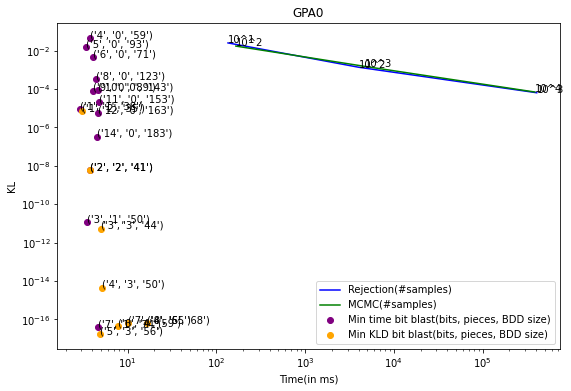

In [11]:
a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_rej_0.txt", "r")
rej = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("GPA0")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = ['10^1', '10^2', '10^3']
kld = [float(j.split(' ')[1]) for j in rej]
time = [float(j.split(' ')[0]) for j in rej]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]

ax1.plot(time, kld, color= "blue")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))


a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_mcmc_0.txt", "r")
mcmc = a.readlines()


t = ['10^2', '10^3', '10^4']
kld = [float(j.split(' ')[2]) for j in mcmc]
time = [float(j.split(' ')[1]) for j in mcmc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]

ax1.plot(time, kld, color= "green")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice if j.split(',')[0] == '0.0']
for j in range(len(dice)):
    temp = dice[j].split(',')
    temp2 = temp[-1].split(' ')
    if temp2[-1][0] == 'm':
        temp3 = float(temp2[0].split('(')[1])
    else:
        temp3 = float(temp2[0].split('(')[1]) * 1000
    
    dice[j] = dice[j] + ',' + str(temp3)
print(dice[0].split(','))

dice_min = []
for i in range(1,15):
    min_time = 100000
    min_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[-1]) < min_time:
                min_time = float(temp[-1])
                min_j = dice[j]
    dice_min.append(min_j)

print(dice_min)

dice_max = []
for i in range(1,15):
    max_time = 0.00
    max_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[5]) > max_time:
                max_time = float(temp[5])
                max_j = dice[j]

    dice_max.append(max_j)

print(dice_max)



    

prob = [0.6115107913669062, 1 - 0.6115107913669062]
t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
time = [float(j.split(',')[7]) for j in dice_min]

ax1.scatter(time, kld, color= "purple")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

dice_min = dice_max
prob = [0.6115107913669062, 1 - 0.6115107913669062]
t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
minprob = [str(abs(prob[0] - float(j.split(',')[5]))) for j in dice_min]
print(min(minprob) + "minprob")
kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
time = [float(j.split(',')[7]) for j in dice_min]

ax1.scatter(time, kld, color= "orange")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

ax1.legend(["Rejection(#samples)", "MCMC(#samples)", "Min time bit blast(bits, pieces, BDD size)", "Min KLD bit blast(bits, pieces, BDD size)"])
fig1.savefig("gpa0.png")

[75.5, 213.0, 5843.5, 572454.5] [1e-05, 1e-05, 1e-05, 1e-05]
['4.0', '1', '0', '17', '23', '0.03883495145631074', 'TrialEstimate(4.883 ms)\n', '4.883']
['4.0,1,1,16,22,0.01981448648395271,TrialEstimate(2.608 ms)\n,2.608', '4.0,2,0,21,27,0.07476635514018704,TrialEstimate(2.683 ms)\n,2.683', '4.0,3,0,25,31,0.13913043478260897,TrialEstimate(2.720 ms)\n,2.72', '4.0,4,0,26,32,0.24427480915337976,TrialEstimate(2.768 ms)\n,2.768', '4.0,5,0,33,39,0.3926380369687647,TrialEstimate(2.929 ms)\n,2.929', '4.0,6,0,32,38,0.5638766484288876,TrialEstimate(2.960 ms)\n,2.96', '4.0,7,0,35,41,0.7211267334555951,TrialEstimate(3.017 ms)\n,3.017', '4.0,8,0,45,51,0.8379710167464491,TrialEstimate(3.230 ms)\n,3.23', '4.0,9,0,41,47,0.9118431143816516,TrialEstimate(3.267 ms)\n,3.267', '4.0,10,0,53,59,0.9538945175525642,TrialEstimate(3.497 ms)\n,3.497', '4.0,11,0,57,63,0.9764018832537384,TrialEstimate(3.653 ms)\n,3.653', '4.0,12,0,61,67,0.9880597015145128,TrialEstimate(3.805 ms)\n,3.805']
['4.0,1,0,17,23,0.038834951

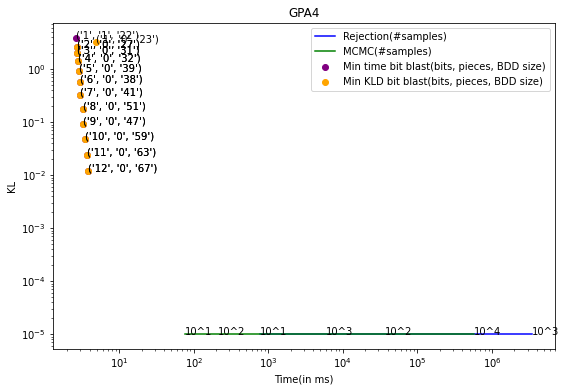

In [12]:
a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_rej_4.txt", "r")
rej = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("GPA4")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = ['10^1', '10^2', '10^3']
kld = [float(j.split(' ')[1]) for j in rej]
kld = margin(kld)
time = [float(j.split(' ')[0]) for j in rej]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]


ax1.plot(time, kld, color= "blue")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))


a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_mcmc_4.txt", "r")
mcmc = a.readlines()


t = ['10^1','10^2', '10^3', '10^4']
kld = [float(j.split(' ')[1]) for j in mcmc]
kld = margin(kld)
time = [float(j.split(' ')[0]) for j in mcmc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]
print(time, kld)
ax1.plot(time, kld, color= "green")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice if j.split(',')[0] == '4.0']
for j in range(len(dice)):
    temp = dice[j].split(',')
    temp2 = temp[-1].split(' ')
    if temp2[-1][0] == 'm':
        temp3 = float(temp2[0].split('(')[1])
    else:
        temp3 = float(temp2[0].split('(')[1]) * 1000
    
    dice[j] = dice[j] + ',' + str(temp3)
print(dice[0].split(','))

dice_min = []
for i in range(1,13):
    min_time = 100000
    min_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[-1]) < min_time:
                min_time = float(temp[-1])
                min_j = dice[j]
    dice_min.append(min_j)

print(dice_min)

dice_max = []
for i in range(1,13):
    max_time = 0.00
    max_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[5]) > max_time:
                max_time = float(temp[5])
                max_j = dice[j]

    dice_max.append(max_j)

print(dice_max)



    

prob = [1, 0]
t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
time = [float(j.split(',')[7]) for j in dice_min]

ax1.scatter(time, kld, color= "purple")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

dice_min = dice_max
prob = [1, 0]
t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
time = [float(j.split(',')[7]) for j in dice_min]

ax1.scatter(time, kld, color= "orange")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

ax1.legend(["Rejection(#samples)", "MCMC(#samples)", "Min time bit blast(bits, pieces, BDD size)", "Min KLD bit blast(bits, pieces, BDD size)"])
fig1.savefig("gpa4.png")

[109.5, 212.0, 2417.0, 177165.0] [1e-05, 1e-05, 1e-05, 1e-05]
['8.0', '1', '0', '3', '6', '0.0', 'TrialEstimate(2.587 ms)\n', '2.587']
['8.0,1,0,3,6,0.0,TrialEstimate(2.587 ms)\n,2.587', '8.0,2,0,3,6,0.0,TrialEstimate(2.662 ms)\n,2.662', '8.0,3,0,3,6,0.0,TrialEstimate(2.736 ms)\n,2.736', '8.0,4,0,3,6,0.0,TrialEstimate(2.783 ms)\n,2.783', '8.0,5,0,3,6,0.0,TrialEstimate(2.921 ms)\n,2.921', '8.0,6,0,3,6,0.0,TrialEstimate(2.946 ms)\n,2.946', '8.0,7,0,3,6,0.0,TrialEstimate(3.029 ms)\n,3.029', '8.0,8,0,3,6,0.0,TrialEstimate(3.222 ms)\n,3.222', '8.0,9,0,3,6,0.0,TrialEstimate(3.221 ms)\n,3.221', '8.0,10,0,3,6,0.0,TrialEstimate(3.444 ms)\n,3.444', '8.0,11,0,3,6,0.0,TrialEstimate(3.585 ms)\n,3.585', '8.0,12,0,3,6,0.0,TrialEstimate(3.697 ms)\n,3.697']
['8.0,1,0,3,6,0.0,TrialEstimate(2.587 ms)\n,2.587', '8.0,2,0,3,6,0.0,TrialEstimate(2.662 ms)\n,2.662', '8.0,3,0,3,6,0.0,TrialEstimate(2.736 ms)\n,2.736', '8.0,4,0,3,6,0.0,TrialEstimate(2.783 ms)\n,2.783', '8.0,5,0,3,6,0.0,TrialEstimate(2.921 ms)\n,2

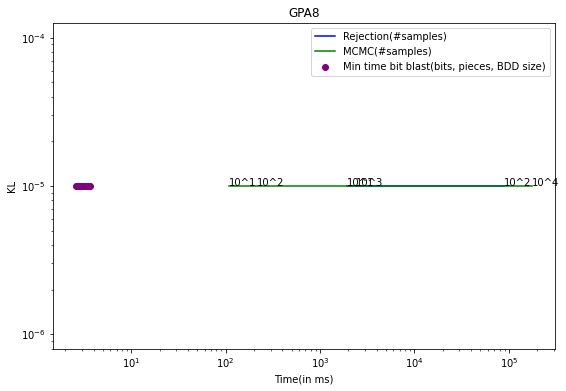

In [13]:
a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_rej_8.txt", "r")
rej = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('KL')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("GPA8")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = ['10^1', '10^2']
kld = [float(j.split(' ')[1]) for j in rej]
kld = margin(kld)
time = [float(j.split(' ')[0]) for j in rej]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]


ax1.plot(time, kld, color= "blue")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))


a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_mcmc_8.txt", "r")
mcmc = a.readlines()


t = ['10^1','10^2', '10^3', '10^4']
kld = [float(j.split(' ')[1]) for j in mcmc]
kld = margin(kld)
time = [float(j.split(' ')[0]) for j in mcmc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]
print(time, kld)
ax1.plot(time, kld, color= "green")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/gpa_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice if j.split(',')[0] == '8.0']
for j in range(len(dice)):
    temp = dice[j].split(',')
    temp2 = temp[-1].split(' ')
    if temp2[-1][0] == 'm':
        temp3 = float(temp2[0].split('(')[1])
    else:
        temp3 = float(temp2[0].split('(')[1]) * 1000
    
    dice[j] = dice[j] + ',' + str(temp3)
print(dice[0].split(','))

dice_min = []
for i in range(1,13):
    min_time = 100000
    min_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[-1]) < min_time:
                min_time = float(temp[-1])
                min_j = dice[j]
    dice_min.append(min_j)

print(dice_min)

dice_max = []
for i in range(1,13):
    max_time = 1.00
    max_j = []
    for j in range(len(dice)):
        temp = dice[j].split(',')
        if float(temp[1]) == i:
            if float(temp[5]) < max_time:
                max_time = float(temp[5])
                max_j = dice[j]

    dice_max.append(max_j)

print(dice_max)



    

prob = [0, 1]
t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
time = [float(j.split(',')[7]) for j in dice_min]
kld= margin(kld)
ax1.scatter(time, kld, color= "purple")

# for i in range(len(t)):
#     ax1.annotate(t[i], (time[i], kld[i]))

# dice_min = dice_max
# prob = [0, 1]
# t = [(j.split(',')[1], j.split(',')[2], j.split(',')[4]) for j in dice_min]
# kld = [sum(rel_entr(prob, [float(j.split(',')[5]), 1 - float(j.split(',')[5])])) for j in dice_min]
# time = [float(j.split(',')[7]) for j in dice_min]
# kld = margin(kld)
# ax1.scatter(time, kld, color= "orange")

# for i in range(len(t)):
#     ax1.annotate(t[i], (time[i], kld[i]))

ax1.legend(["Rejection(#samples)", "MCMC(#samples)", "Min time bit blast(bits, pieces, BDD size)", "Min KLD bit blast(bits, pieces, BDD size)"])

fig1.savefig("gpa8.png")

Radar Query 1 (Uniform + Gaussian)

0.00024414061698152523
-4.445113432893777e-08


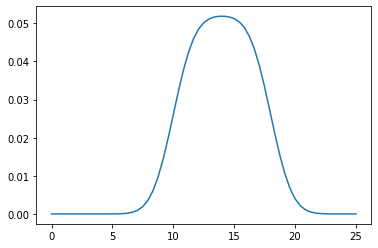

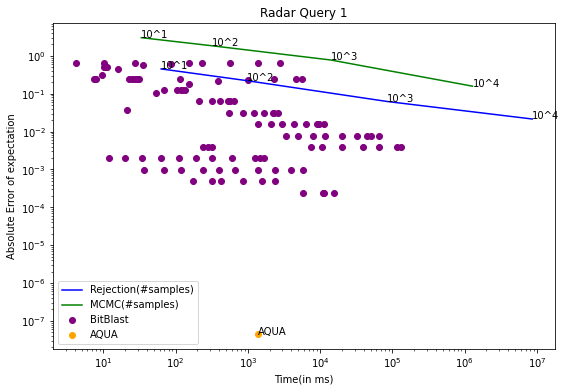

In [86]:
AQUA_mean, AQUA_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/storm_bench/radar_query2/analysis_x2.txt")
gt_mean, gt_variance = 14, 64/12 + 1.414**2
 
a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/rq1_rej.txt", "r")
rej = a.readlines()

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of expectation')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Radar Query 1")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)


t = ['10^1', '10^2', '10^3', '10^4']
kld = [float(j.split(' ')[1]) for j in rej]
time = [float(j.split(' ')[0]) for j in rej]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]


ax1.plot(time, kld, color= "blue")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))


a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/rq1_mcmc.txt", "r")
mcmc = a.readlines()


t = ['10^1','10^2', '10^3', '10^4']
kld = [float(j.split(' ')[1]) for j in mcmc]
# kld = margin(kld)
time = [float(j.split(' ')[0]) for j in mcmc]
# tic = [(t[i], pi_julia_bdd[i]) for i in range(0, 18)]
# print(time, kld)
ax1.plot(time, kld, color= "green")

for i in range(len(t)):
    ax1.annotate(t[i], (time[i], kld[i]))

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/rq1_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice]

t = []
abs_err = []
time = []
for j in range(len(dice)):
    # print(temp[6])
    temp = dice[j].split(',')
    t.append((temp[0], temp[1], temp[3]))
    abs_err.append(abs(float(temp[6].split('(')[-1]) - 14))
    time.append(temp[4].split('(')[-1])

print(min(abs_err))

for k in range(len(time)):
    if time[k][-3:] == 'ms)':
        time[k] = float(time[k].split(' ')[0])
    elif time[k][-2:] == 's)':
        time[k] = float(time[k].split(' ')[0]) * 1000
    else:
        time[k] = float(time[k])


ax1.scatter(time, abs_err, color= "purple")
print(AQUA_mean - gt_mean)
AQUA_pt = [1368.760479, abs(gt_mean - AQUA_mean)]
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')

ax1.annotate('AQUA', AQUA_pt)
bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture.csv", "a")
bpfile.write("radar_query1, b, " + str(min(abs_err)) + ", " + str(AQUA_pt[1]))
bpfile.close()
ax1.legend(["Rejection(#samples)", "MCMC(#samples)", "BitBlast", "AQUA"])

fig1.savefig("rq1_results.png")


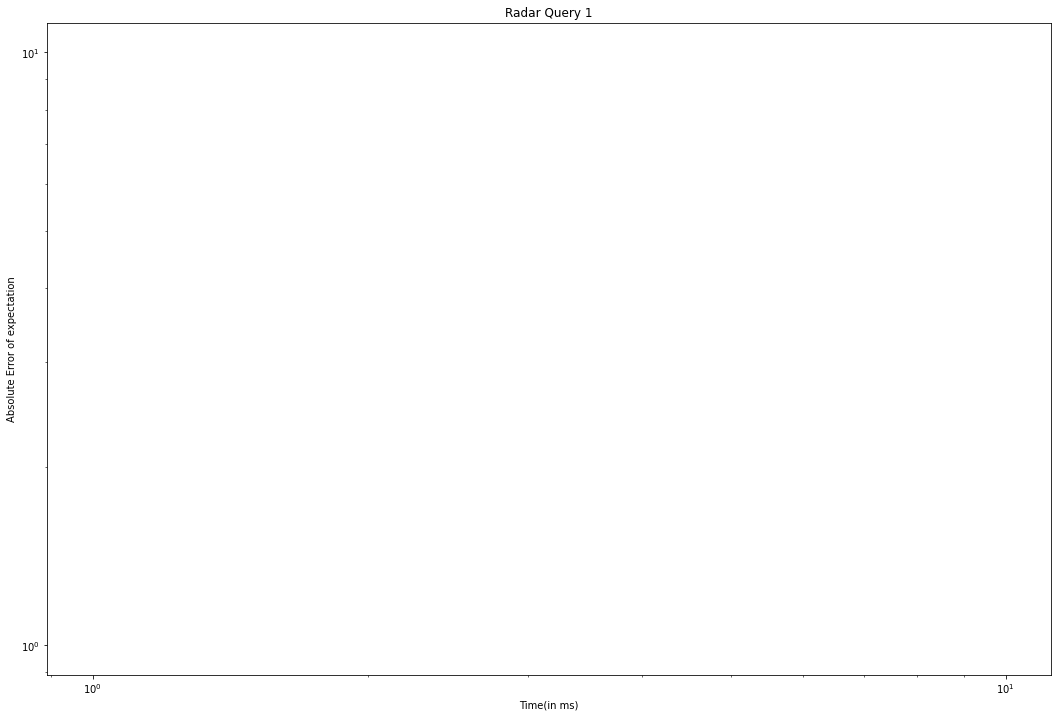

In [87]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of expectation')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Radar Query 1")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/rq1_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice]

t = []
abs_err = []
time = []
bits = []
for j in range(len(dice)):
    # print(temp[6])
    temp = dice[j].split(',')
    # if float(temp[0]) == 5:
    t.append((temp[0], temp[1], temp[3]))
    bits.append(float(temp[0]))
    abs_err.append(abs(float(temp[6].split('(')[-1]) - 14))
    time.append(temp[4].split('(')[-1])

# print(time)

for k in range(len(time)):
    if time[k][-3:] == 'ms)':
        time[k] = float(time[k].split(' ')[0])
    elif time[k][-2:] == 's)':
        time[k] = float(time[k].split(' ')[0]) * 1000
    else:
        time[k] = float(time[k])


In [89]:
def plot_indiv(no, fig1, ax1):
    # fig1, ax1 = plt.subplots()
    ax1.set_ylabel('Absolute Error of expectation')
    ax1.set_xscale("log")
    ax1.set_xlabel('Time(in ms)')
    ax1.set_yscale("log")
    ax1.set_title("Radar Query 1" + str(no))

    fig1.set_facecolor('white')
    fig1.set_size_inches(18, 12)

    t = []
    abs_err = []
    time = []
    bits = []
    for j in range(len(dice)):
        # print(temp[6])
        temp = dice[j].split(',')
        if float(temp[0]) == no:
            t.append((temp[0], temp[1], temp[3]))
            bits.append(float(temp[0]))
            abs_err.append(abs(float(temp[6].split('(')[-1]) - 14))
            time.append(temp[4].split('(')[-1])

    # print(t)
    # print(bits)
    # print(abs_err)
    # print(time)

    for k in range(len(time)):
        if time[k][-3:] == 'ms)':
            time[k] = float(time[k].split(' ')[0])
        elif time[k][-2:] == 's)':
            time[k] = float(time[k].split(' ')[0]) * 1000
        else:
            time[k] = float(time[k]) * 1000

    ax1.plot(time, abs_err, color="purple")

    for i in range(len(t)):
        ax1.annotate(t[i], (time[i], abs_err[i]))

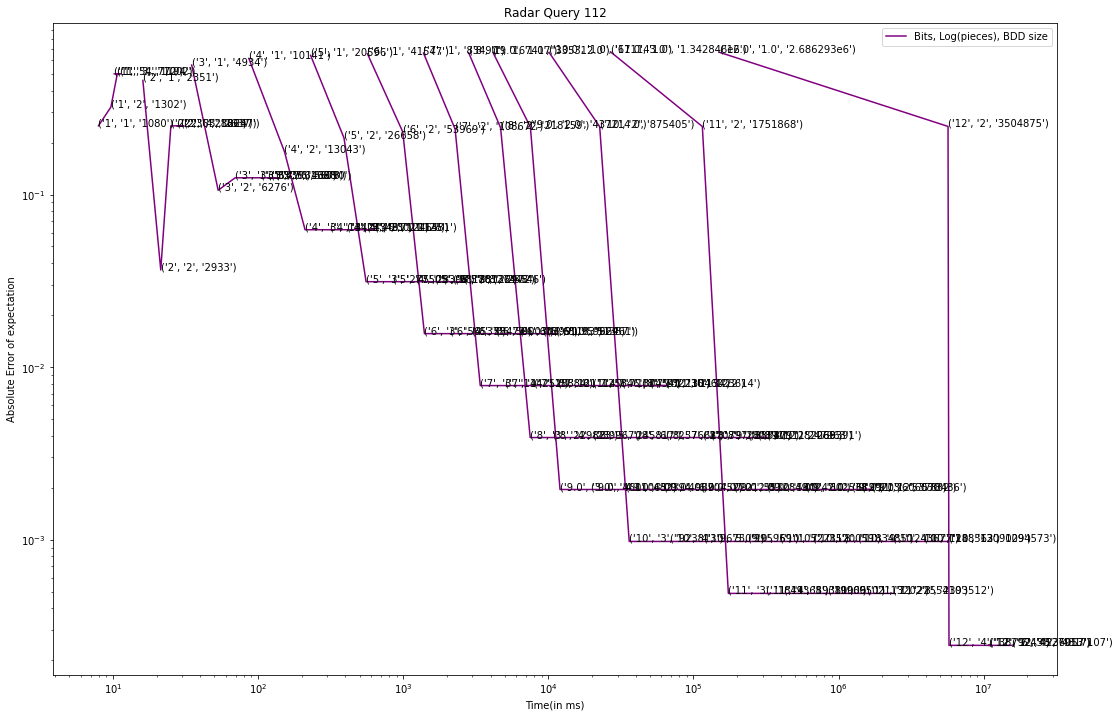

In [90]:
fig, ax = plt.subplots()

plot_indiv(1, fig, ax)
plot_indiv(2, fig, ax)
plot_indiv(3, fig, ax)
plot_indiv(4, fig, ax)
plot_indiv(5, fig, ax)
plot_indiv(6, fig, ax)
plot_indiv(7, fig, ax)
plot_indiv(8, fig, ax)
plot_indiv(9, fig, ax)
plot_indiv(10, fig, ax)
plot_indiv(11, fig, ax)
plot_indiv(12, fig, ax)

fig.savefig("rq1.png")
ax.legend(["Bits, Log(pieces), BDD size"])

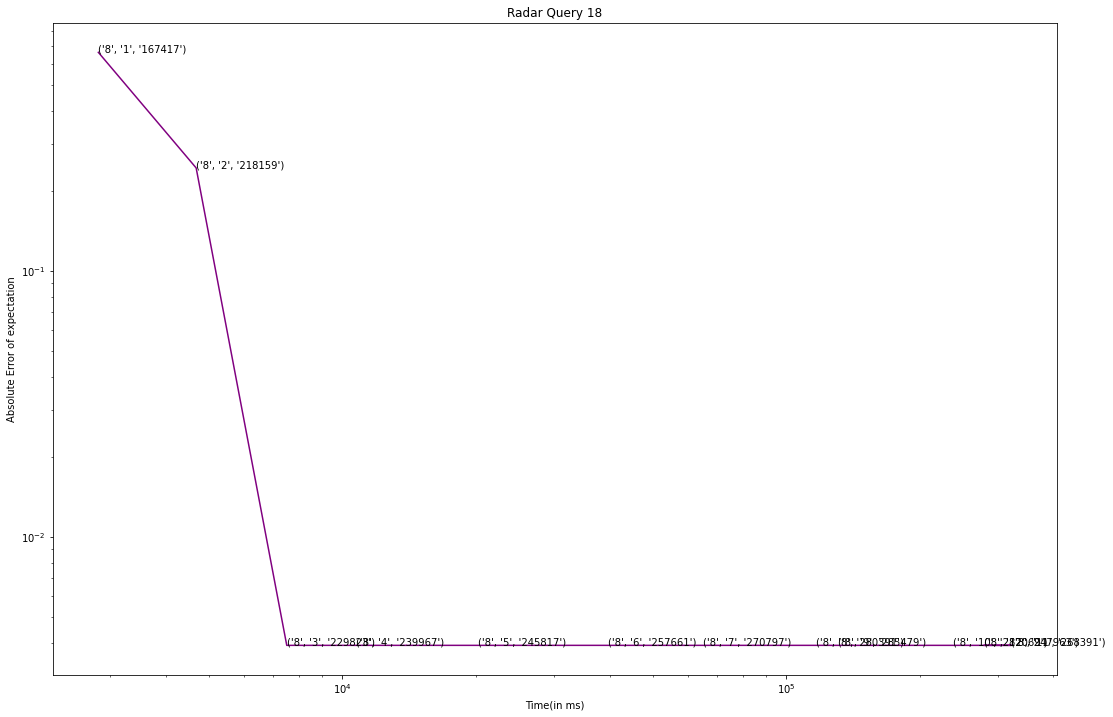

In [91]:
fig, ax = plt.subplots()
plot_indiv(8, fig, ax)


# fig.savefig("rq1.png")

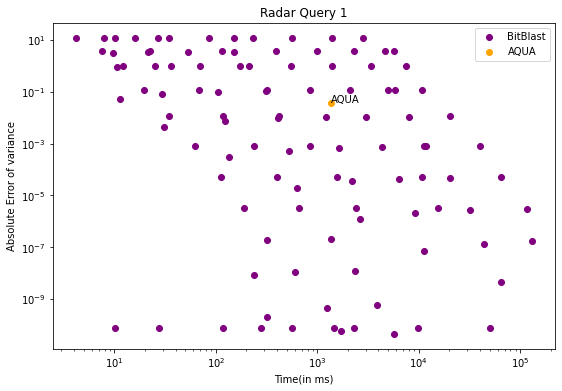

In [92]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of variance')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Radar Query 1")

fig1.set_facecolor('white')
fig1.set_size_inches(9, 6)

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/rq1_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice]

t = []
abs_err = []
time = []
for j in range(len(dice)):
    temp = dice[j].split(',')
    t.append((temp[0], temp[1], temp[3]))
    abs_err.append(abs(float(temp[-1]) - 7.332729333333333))
    time.append(temp[4].split('(')[-1])

for k in range(len(time)):
    if time[k][-3:] == 'ms)':
        time[k] = float(time[k].split(' ')[0])
    elif time[k][-2:] == 's)':
        time[k] = float(time[k].split(' ')[0]) * 1000
    else:
        time[k] = float(time[k])

ax1.scatter(time, abs_err, color= "purple")

ax1.scatter([1368.760479], [0.03703752064430432], color = 'orange')
AQUA_pt = (1368.760479, 0.03703752064430432)
ax1.annotate('AQUA', (1368.760479, 0.03703752064430432))

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
bpfile.write("radar_query1, b, " + str(min(abs_err)) + ", " + str(AQUA_pt[1]))
bpfile.close()

ax1.legend(["BitBlast", "AQUA"])

# fig1.legend("")
fig1.savefig("rq1_results.png")

In [20]:
def plot_indiv_variance(no, fig1, ax1):
    # fig1, ax1 = plt.subplots()
    ax1.set_ylabel('Absolute Error of Variance')
    ax1.set_xscale("log")
    ax1.set_xlabel('Time(in ms)')
    ax1.set_yscale("log")
    ax1.set_title("Radar Query 1" + str(no))

    fig1.set_facecolor('white')
    fig1.set_size_inches(18, 12)

    t = []
    abs_err = []
    time = []
    bits = []
    for j in range(len(dice)):
        # print(temp[6])
        temp = dice[j].split(',')
        if float(temp[0]) == no:
            t.append((temp[0], temp[1], temp[3]))
            bits.append(float(temp[0]))
            abs_err.append(abs(float(temp[-1]) - 7.332729333333333))
            time.append(temp[5].split('(')[-1])

    # print(t)
    # print(bits)
    # print(abs_err)
    # print(time)

    for k in range(len(time)):
        if time[k][-3:] == 'ms)':
            time[k] = float(time[k].split(' ')[0])
        elif time[k][-2:] == 's)':
            time[k] = float(time[k].split(' ')[0]) * 1000
        else:
            time[k] = float(time[k]) * 1000

    ax1.plot(time, abs_err, color="purple")

    for i in range(len(t)):
        ax1.annotate(t[i], (time[i], abs_err[i]))

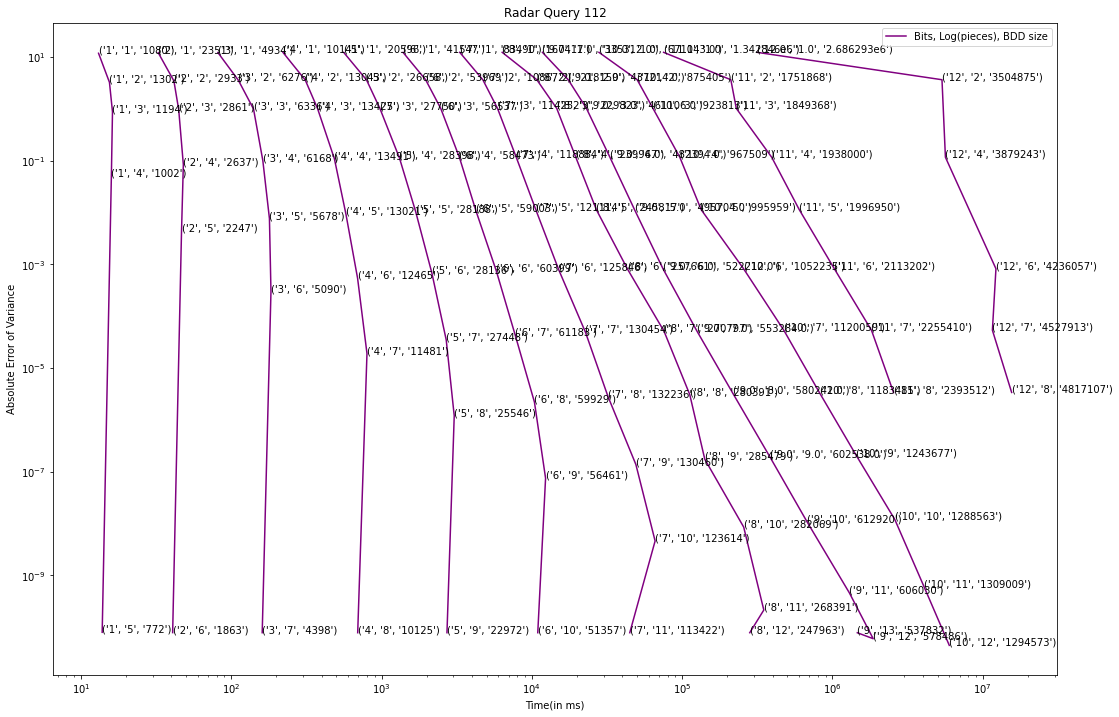

In [21]:
fig, ax = plt.subplots()

for i in range(1, 13):
    plot_indiv_variance(i, fig, ax)

fig.savefig("rq1.png")
ax.legend(["Bits, Log(pieces), BDD size"])

Altermu2    

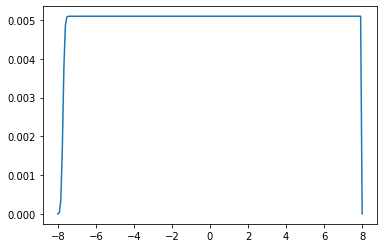

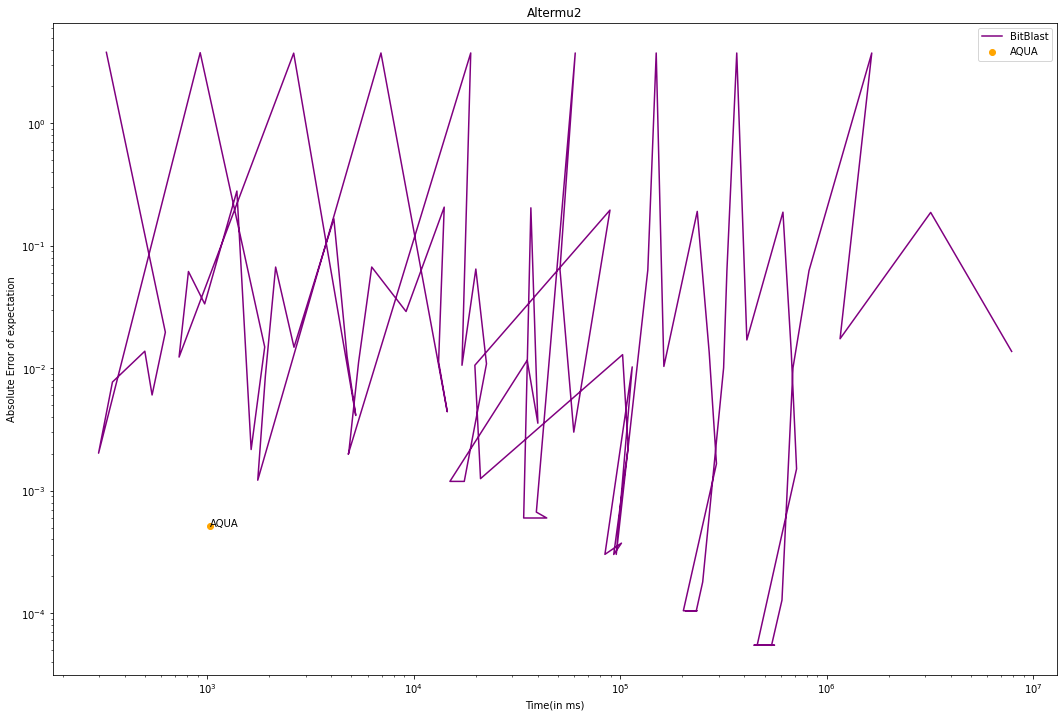

In [93]:
AQUA_time = 1.032172729 * 1000
gt_mean = (1.51251662585150465e-01 + 1.58960572270531064e-01)/2
gt_variance = 4.52785577875832512 ** 2

#TODO: check this
AQUA_mean, AQUA_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/altermu2/analysis_mu[1].txt")

AQUA_mean = 0.1556196223786136
AQUA_variance = 20.304334302261715



fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of expectation')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu2")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu2_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice]

t = []
abs_err = []
time = []


for j in range(31):
    temp = dice[j].split(',')
    # print(temp)
    t.append((temp[0], temp[1], temp[3]))

    temp2 = abs(float(temp[4].split("(")[-1]) - gt_mean)
    abs_err.append(temp2)

    temp3 = temp[7].split('(')[-1]
    time.append(temp3)

for j in range(31,len(dice)):
    temp = dice[j].split(',')
    # print(temp)
    t.append((temp[0], temp[1], temp[3]))

    temp2 = abs(float(temp[6].split("(")[-1]) - gt_mean)
    abs_err.append(temp2)

    temp3 = temp[4].split('(')[-1]
    time.append(temp3)

# for j in range(len(dice)):
#     temp = dice[j].split(',')
#     t.append((temp[0], temp[1], temp[3]))
#     abs_err.append(abs(float(temp[4].split('(')[0]) - gt_mean))
#     time.append(temp[7].split('(')[-1])

for k in range(len(dice)):
    if time[k][-3:] == 'ms)':
        time[k] = float(time[k].split(' ')[0])
    elif time[k][-2:] == 's)':
        time[k] = float(time[k].split(' ')[0]) * 1000
    else:
        time[k] = float(time[k])*1000

ax1.plot(time, abs_err, color= "purple")

AQUA_pt = (AQUA_time, abs(AQUA_mean - gt_mean))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture.csv", "a")
bpfile.write("altermu2, mu[1], " + str(min(abs_err)) + ", " + str(AQUA_pt[1]))
bpfile.close()

ax1.legend(["BitBlast", "AQUA"])

# fig1.legend("")
fig1.savefig("altermu2_results_mean.png")



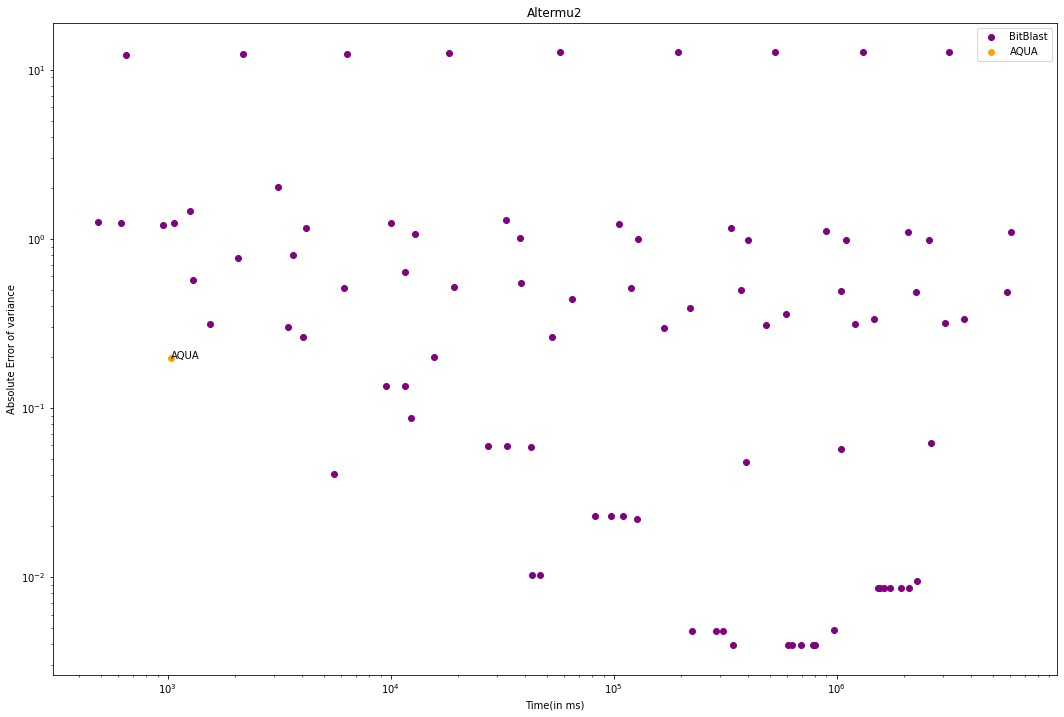

In [95]:
AQUA_time = 1.032172729 * 1000
gt_mean = (1.51251662585150465e-01 + 1.58960572270531064e-01)/2
gt_variance = 4.52785577875832512 ** 2

AQUA_mean = 0.1556196223786136
AQUA_variance = 20.304334302261715



fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of variance')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu2")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

a = open("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu2_res.txt", "r")
dice = a.readlines()
dice = [j for j in dice]

t = []
abs_err = []
time = []


for j in range(31):
    temp = dice[j].split(',')
    # print(temp)
    t.append((temp[0], temp[1], temp[3]))

    temp2 = abs(float(temp[-2].split("(")[-1]) - gt_variance)
    abs_err.append(temp2)

    temp3 = temp[-1].split('(')[-1]
    time.append(temp3)

for j in range(31,len(dice)):
    temp = dice[j].split(',')
    # print(temp)
    t.append((temp[0], temp[1], temp[3]))

    temp2 = abs(float(temp[-1].split("(")[-1]) - gt_variance)
    abs_err.append(temp2)

    temp3 = temp[5].split('(')[-1]
    time.append(temp3)


for k in range(len(dice)):
    if time[k][-4:] == 'ms)\n' :
        time[k] = float(time[k].split(' ')[0])
    elif time[k][-3:] == 's)\n':
        time[k] = float(time[k].split(' ')[0]) * 1000
    else:
        time[k] = float(time[k])*1000

ax1.scatter(time, abs_err, color= "purple")

AQUA_pt = (AQUA_time, abs(AQUA_variance - gt_variance))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
bpfile.write("altermu2, mu[1], " + str(min(abs_err)) + ", " + str(AQUA_pt[1]))
bpfile.close()

ax1.legend(["BitBlast", "AQUA"])

# fig1.legend("")
fig1.savefig("altermu2_results_variance.png")

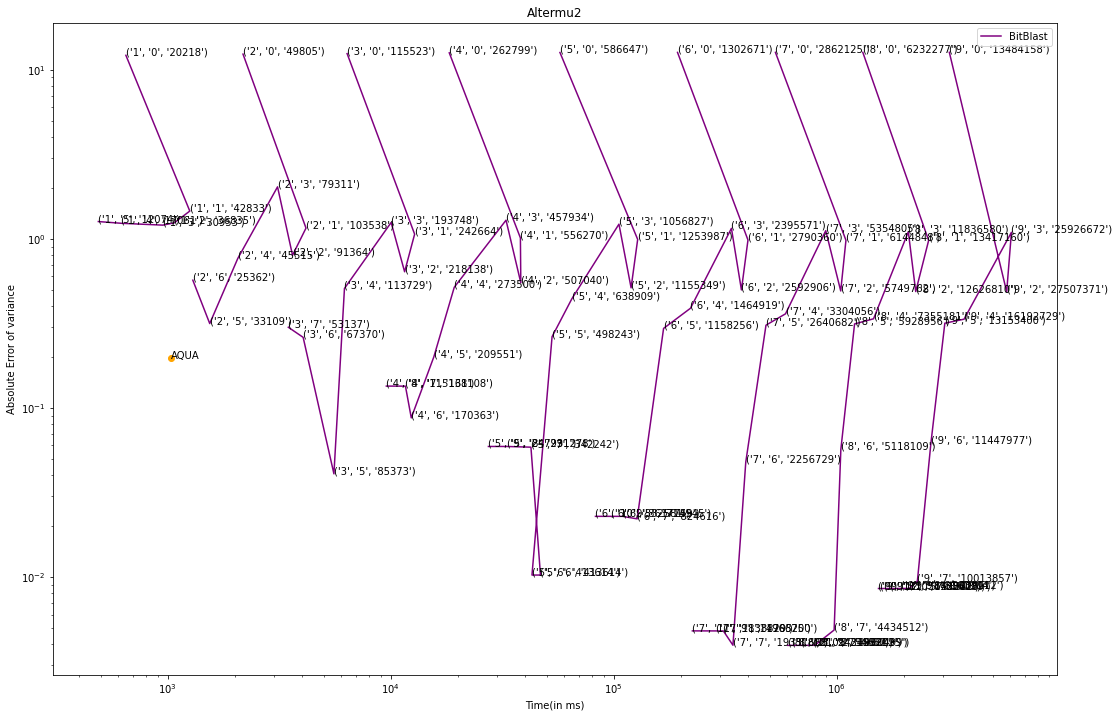

In [24]:


def plot_indiv_variance(file, gt_variance, title, no, fig1, ax1):

    a = open(file, "r")
    dice = a.readlines()

    dice = [(float(j.split(',')[1]), j) for j in dice if float(j.split(',')[0]) == no]
    dice.sort()

    dice = [j[1] for j in dice]

    t = []
    abs_err = []
    time = []


    for j in range(len(dice)):
        # print(dice[j][-2])
        if dice[j][-2] == ")":
            temp = dice[j].split(',')
            # print(temp)
            t.append((temp[0], temp[1], temp[3]))

            temp2 = abs(float(temp[-2].split("(")[-1]) - gt_variance)
            abs_err.append(temp2)

            temp3 = temp[-1].split('(')[-1]
            time.append(temp3)
        else:
            temp = dice[j].split(',')
            # print(temp)
            t.append((temp[0], temp[1], temp[3]))

            temp2 = abs(float(temp[-1].split("(")[-1]) - gt_variance)
            abs_err.append(temp2)

            temp3 = temp[5].split('(')[-1]
            time.append(temp3)


    for k in range(len(dice)):
        if time[k][-4:] == 'ms)\n' :
            time[k] = float(time[k].split(' ')[0])
        elif time[k][-3:] == 's)\n':
            time[k] = float(time[k].split(' ')[0]) * 1000
        else:
            time[k] = float(time[k])*1000

    ax1.plot(time, abs_err, color= "purple")
    for i in range(len(t)):
        ax1.annotate(t[i], (time[i], abs_err[i]))




fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of variance')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu2")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)
for no in range(1, 13):
    plot_indiv_variance("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu2_res.txt", gt_variance, "Altermu2", no, fig1, ax1)
AQUA_pt = (AQUA_time, abs(AQUA_variance - gt_variance))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

ax1.legend(["BitBlast"])

# fig1.legend("")
fig1.savefig("altermu2_results_variance.png")
    

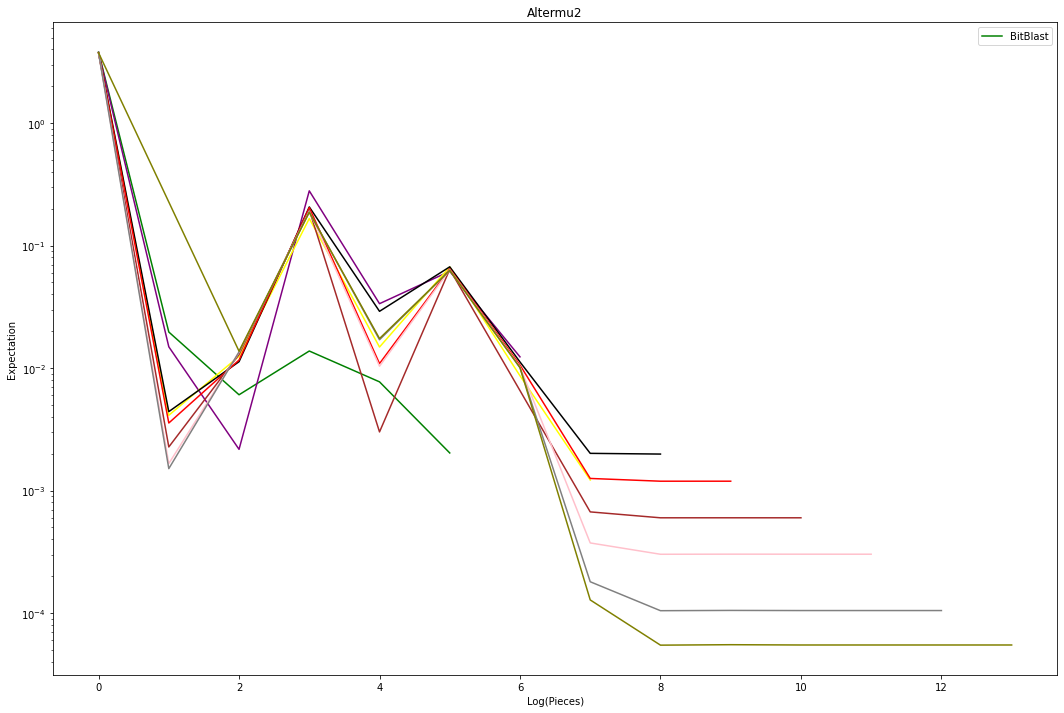

In [25]:
def plot_indiv_mean(file, gt_variance, title, no, fig1, ax1):

    a = open(file, "r")
    dice = a.readlines()

    dice = [(float(j.split(',')[1]), j) for j in dice if float(j.split(',')[0]) == no]
    dice.sort()

    dice = [j[1] for j in dice]

    t = []
    abs_err = []
    time = []


    for j in range(len(dice)):
        # print(dice[j][-2])
        if dice[j][-2] == ")":
            temp = dice[j].split(',')
            # print(temp)
            t.append((temp[0], temp[1], temp[3]))

            temp2 = abs(float(temp[4].split("(")[-1]) - gt_mean)
            abs_err.append(temp2)

            temp3 = temp[7].split('(')[-1]
            temp3 = int(temp[1])
            time.append(temp3)
        else:
            temp = dice[j].split(',')
            # print(temp)
            t.append((temp[0], temp[1], temp[3]))

            temp2 = abs(float(temp[6].split("(")[-1]) - gt_mean)
            abs_err.append(temp2)

            temp3 = temp[4].split('(')[-1]
            temp3 = int(temp[1])
            time.append(temp3)


    # for k in range(len(dice)):
    #     if time[k][-3:] == 'ms)' :
    #         time[k] = float(time[k].split(' ')[0])
    #     elif time[k][-2:] == 's)':
    #         time[k] = float(time[k].split(' ')[0]) * 1000
    #     else:
    #         time[k] = float(time[k])*1000

    ax1.plot(time, abs_err, color= colors[no])
    # for i in range(len(t)):
        # ax1.annotate(t[i], (time[i], abs_err[i]))




fig1, ax1 = plt.subplots()
ax1.set_ylabel('Expectation')
# ax1.set_xscale("log")
ax1.set_xlabel('Log(Pieces)')
ax1.set_yscale("log")
ax1.set_title("Altermu2")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

# Comment the following line to calculate abolute error of expectation
# gt_mean = 0.0
for no in range(1, 13):
    plot_indiv_mean("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu2_res.txt", gt_mean, "Altermu2", no, fig1, ax1)
AQUA_pt = (AQUA_time, abs(AQUA_mean - gt_mean))
# ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
# ax1.annotate('AQUA', AQUA_pt)

ax1.legend(["BitBlast"])

# fig1.legend("")
fig1.savefig("altermu2_mean.png")

Altermu

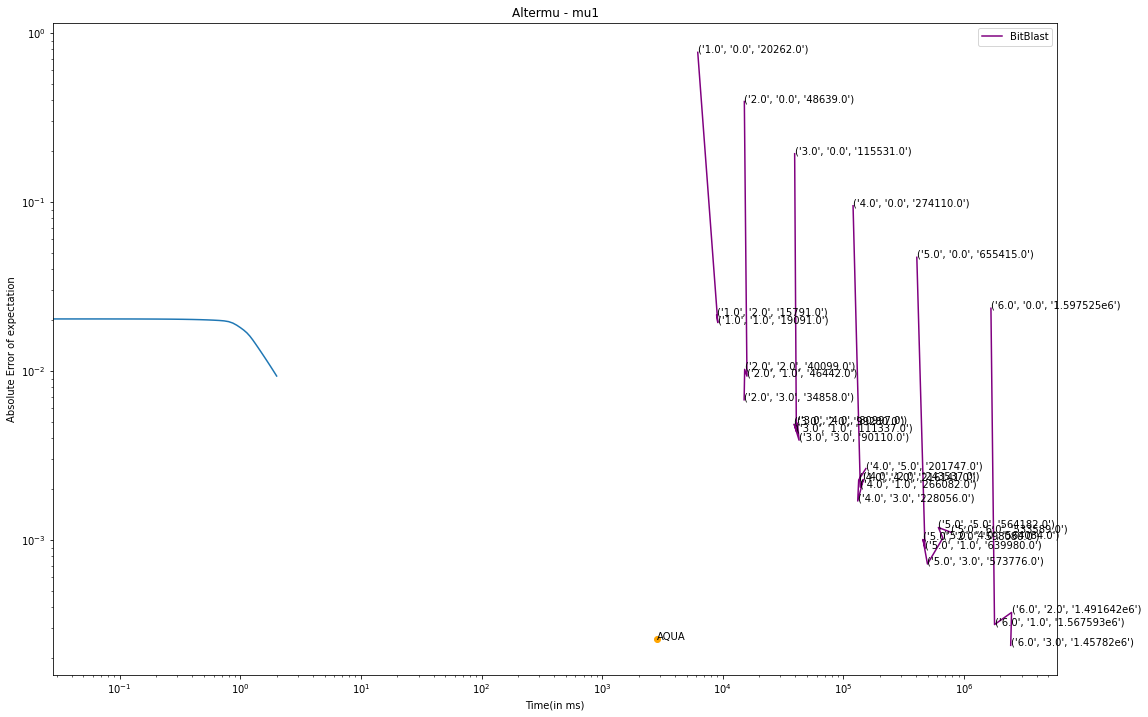

In [96]:
min_res = []

def plot_indiv_mean(file, gt_mean, title, no, fig1, ax1, offset):

    a = open(file, "r")
    dice = a.readlines()

    dice = [(float(j.split(',')[1]), j) for j in dice if float(j.split(',')[0]) == no]
    dice.sort()

    dice = [j[1] for j in dice]

    t = []
    abs_err = []
    time = []


    for j in range(len(dice)):
        temp = dice[j].split(',')
        t.append((temp[0], temp[1], temp[3]))

        temp2 = abs(float(temp[5 + (1 - math.ceil(offset))*2]) + (offset)*1/2**(no+1) - gt_mean)
        abs_err.append(temp2)

        temp3 = float(temp[4 + (1 - math.ceil(offset))*2]) * 1000
        time.append(temp3)
        min_res.append(min(abs_err))
        

    ax1.plot(time, abs_err, color= "purple")
    for i in range(len(t)):
        ax1.annotate(t[i], (time[i], abs_err[i]))

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of expectation')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu - mu1")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

gt_mean = 2.57737e-04
for no in range(1, 7):
    plot_indiv_mean("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu_mu1_res.txt", gt_mean, "Altermu-mu1", no, fig1, ax1, 1/4)


AQUA_mean, AQUA_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/altermu/analysis_mu[1].txt")

AQUA_time = ((3.065353433 + 2.585773617)/2) * 1000
AQUA_pt = (AQUA_time, abs(AQUA_mean - gt_mean))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

ax1.legend(["BitBlast"])

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture.csv", "a")
bpfile.write("altermu, mu[1], " + str(min(min_res)) + ", " + str(AQUA_pt[1]))
bpfile.close()

fig1.savefig("altermu_mu1_results_mean.png")

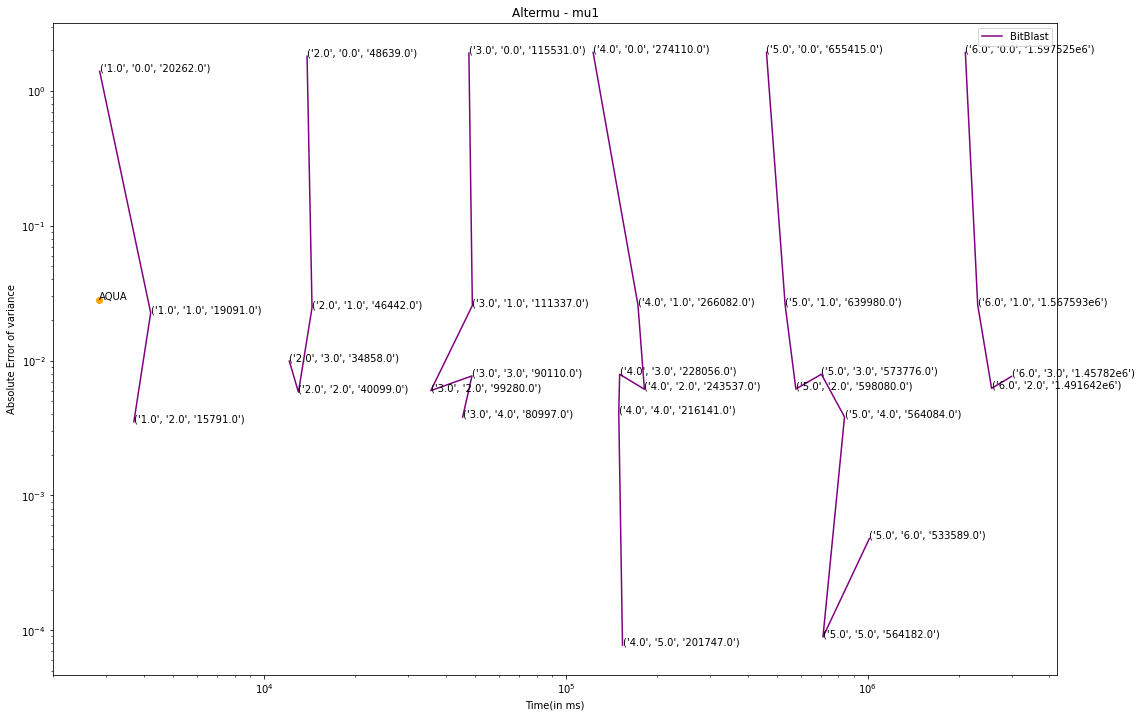

In [97]:
gt_variance = (1.02877e+00)**2

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of variance')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu - mu1")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

gt_mean = 2.57737e-04
for no in range(1, 7):
    plot_indiv_mean("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu_mu1_res.txt", gt_variance, "Altermu-mu1", no, fig1, ax1, 0)


AQUA_time = ((3.065353433 + 2.585773617)/2) * 1000
AQUA_pt = (AQUA_time, abs(AQUA_variance - gt_variance))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
bpfile.write("altermu, mu[1], " + str(min(min_res)) + ", " + str(AQUA_pt[1]))
bpfile.close()

ax1.legend(["BitBlast"])

fig1.savefig("altermu_mu1_results_variance.png")

[1.2861873878947825, 0.06188392763516182, 0.03181299324520592, 1.3179330110212049, 0.04843021365105071, 0.008281464832640473, 0.008281464832640473, 1.3261633478290604, 0.038387804923294744, 0.005716421737612998, 0.005716421737612998, 0.005716421737612998, 1.327834201435253, 0.03907372910964069, 0.004773937103285442, 0.004773937103285442, 0.004773937103285442, 0.004773937103285442, 1.3281483805843766, 0.038963446697778514, 0.004910614051801709, 0.004910614051801709, 0.004910614051801709, 0.004910614051801709, 0.004910614051801709, 1.328160900965107, 0.038016184673168474, 0.006217551047061343, 0.006217551047061343, 0.006217551047061343, 0.006217551047061343, 0.006217551047061343, 0.0008004499456703007]


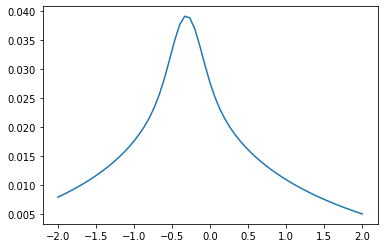

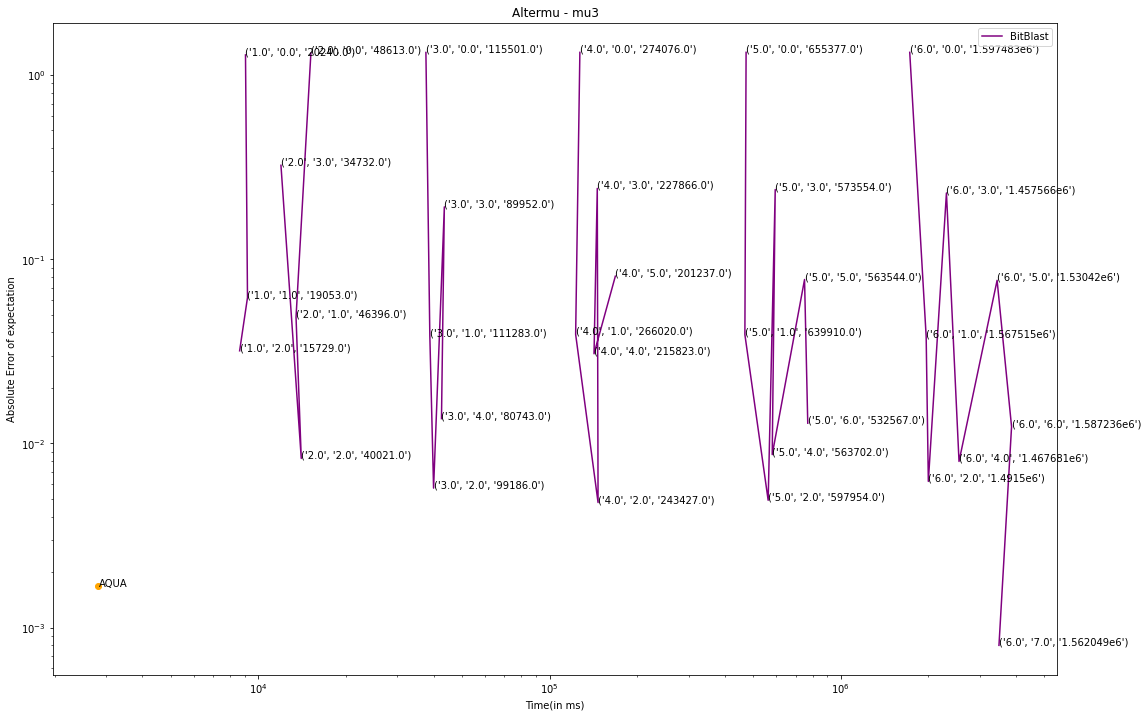

In [98]:
AQUA_mu3_mean, AQUA_mu3_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/altermu/analysis_mu[3].txt")

gt_mean = -1.86373e-01
gt_variance = (8.82885e-01)**2

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of expectation')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu - mu3")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)
min_res = []
for no in range(1, 7):
    plot_indiv_mean("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu_mu3_res.txt", gt_mean, "Altermu-mu3", no, fig1, ax1, 1)


AQUA_time = ((3.065353433 + 2.585773617)/2) * 1000
AQUA_pt = (AQUA_time, abs(AQUA_mu3_mean - gt_mean))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

ax1.legend(["BitBlast"])
print(min_res)
bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture.csv", "a")
bpfile.write("altermu, mu[3], " + str(min(min_res)) + ", " + str(AQUA_pt[1]) + "\n")
bpfile.close()

fig1.savefig("altermu_mu3_results_mean.png")

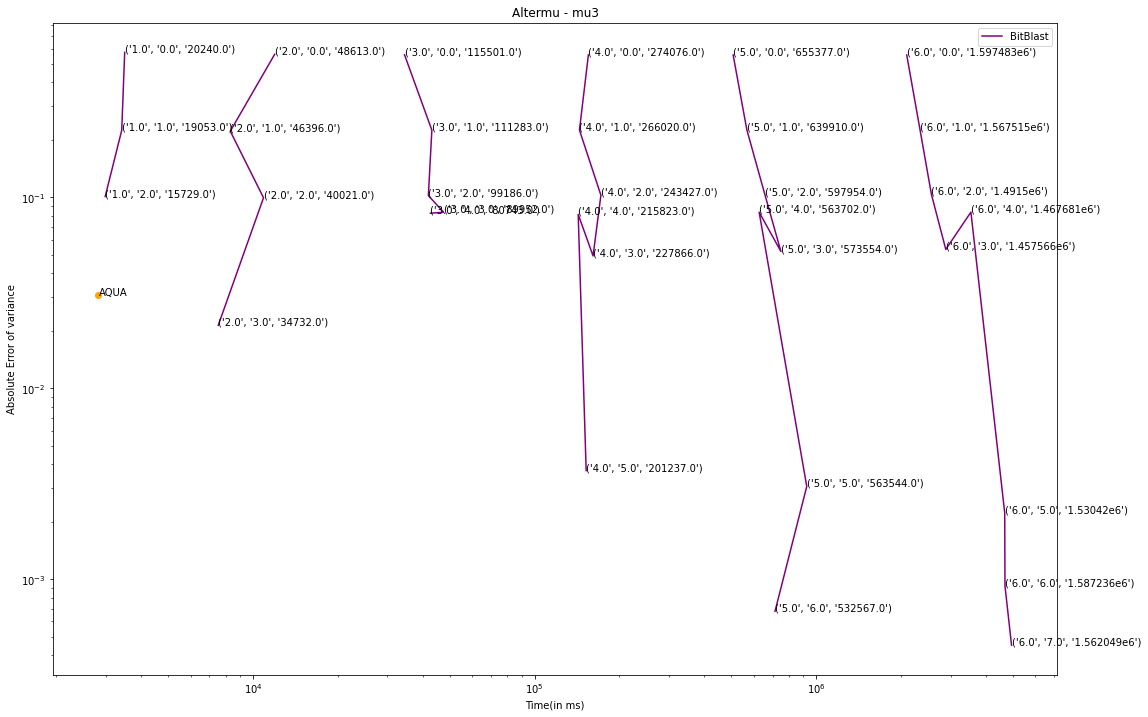

In [99]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Absolute Error of variance')
ax1.set_xscale("log")
ax1.set_xlabel('Time(in ms)')
ax1.set_yscale("log")
ax1.set_title("Altermu - mu3")

fig1.set_facecolor('white')
fig1.set_size_inches(18, 12)

for no in range(1, 7):
    plot_indiv_mean("/home/poorvagarg/.julia/dev/Dice/benchmarks/altermu_mu3_res.txt", gt_variance, "Altermu-mu3", no, fig1, ax1, 0)


AQUA_time = ((3.065353433 + 2.585773617)/2) * 1000
AQUA_pt = (AQUA_time, abs(AQUA_mu3_variance - gt_variance))
ax1.scatter(AQUA_pt[0], AQUA_pt[1], color = 'orange')
ax1.annotate('AQUA', AQUA_pt)

bpfile = open("/home/poorvagarg/.julia/dev/Dice/big_picture_variance.csv", "a")
bpfile.write("altermu, mu[1], " + str(min(min_res)) + ", " + str(AQUA_pt[1]))
bpfile.close()

ax1.legend(["BitBlast"])

fig1.savefig("altermu_mu3_results_variance.png")

Anova Radon NoPred

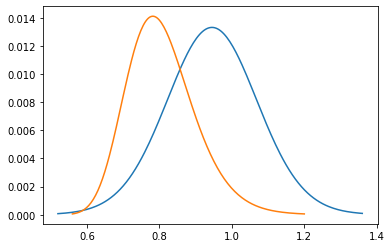

In [30]:
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/anova_radon_nopred/runtime.txt")

AQUA_a1_mean, AQUA_a1_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/anova_radon_nopred/analysis_a[1].txt")
AQUA_sigmay_mean, AQUA_sigmay_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/anova_radon_nopred/analysis_sigma_y.txt")

gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/anova_radon_nopred/summary.txt", ['a[1]', 'sigma_y'])

0.0024350258480135833 9.761422951726217e-05


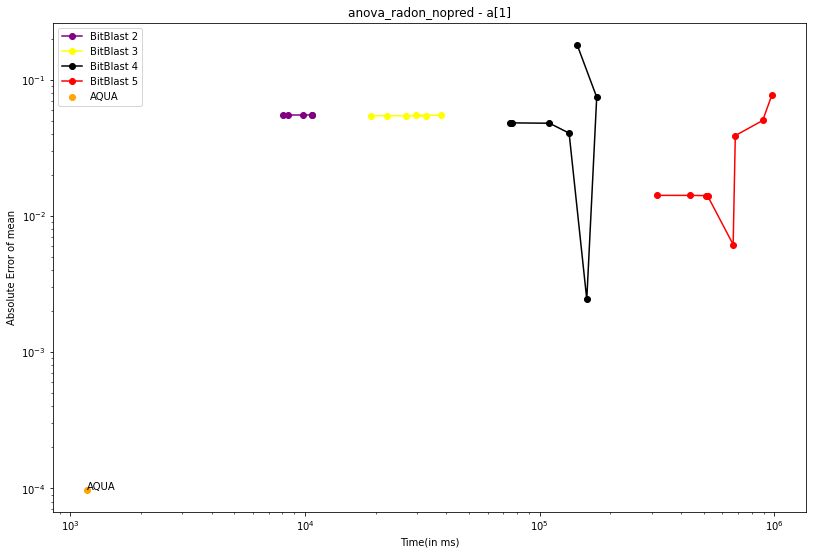

In [31]:
fig, ax = plotting_dice_data('mean', "anova_radon_nopred", "a[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/a1_res.txt",
                            2, 6, 0, gt_mean['a[1]'], AQUA_time, AQUA_a1_mean, False, 's')

7.557935164094823e-05 0.0003701543098170654


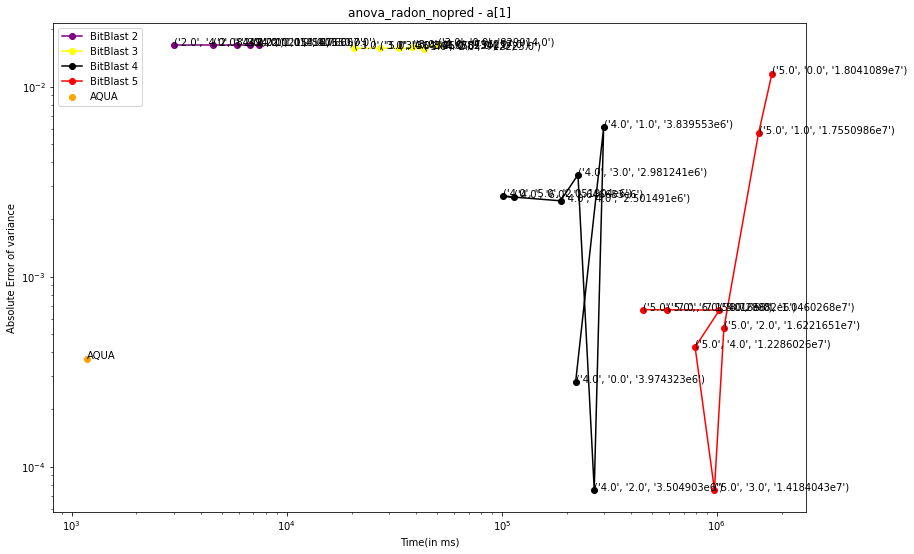

In [32]:
fig, ax = plotting_dice_data('variance', "anova_radon_nopred", "a[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/a1_res.txt",
                            2, 6, 0, gt_variance['a[1]'], AQUA_time, AQUA_a1_variance, True, 's')

0.0009896002657340253 0.000565802022355899


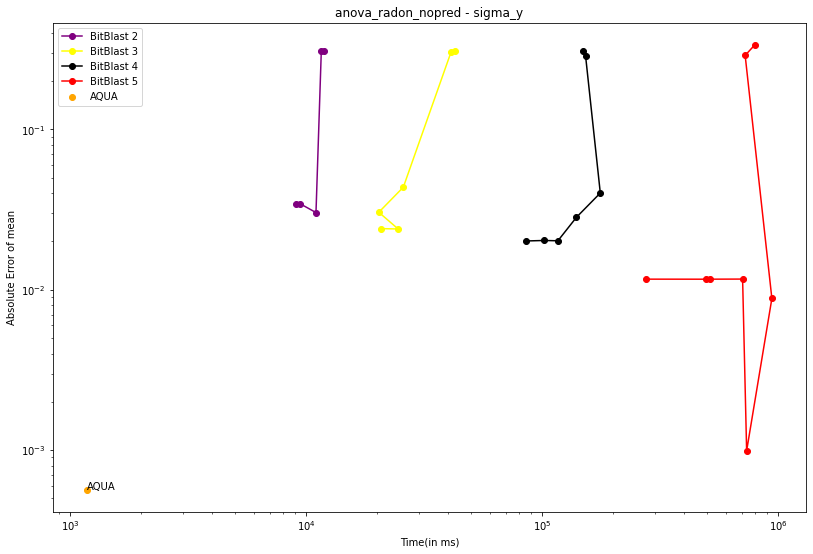

In [33]:
fig, ax = plotting_dice_data('mean', "anova_radon_nopred", "sigma_y", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/sigmay_res.txt",
                            2, 6, 0, gt_mean['sigma_y'], AQUA_time, AQUA_sigmay_mean, False, 's')

0.00016446326106300986 0.00021722745987171055


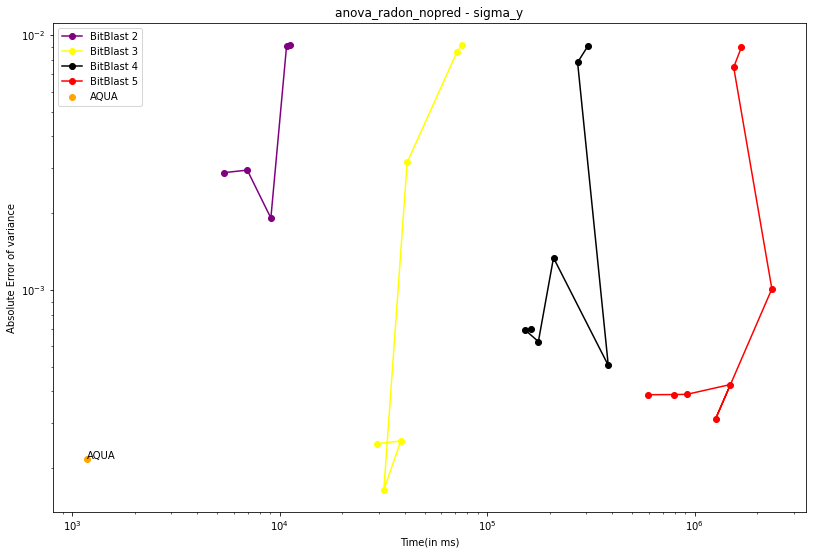

In [34]:
fig, ax = plotting_dice_data('variance', "anova_radon_nopred", "sigma_y", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/anova_radon_nopred/sigmay_res.txt",
                            2, 6, 0, gt_variance['sigma_y'], AQUA_time, AQUA_sigmay_variance, False, 's')

Gamma Transform

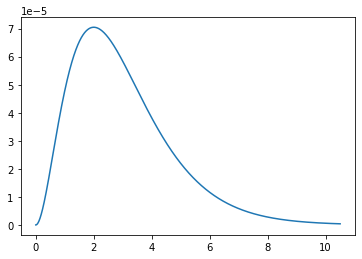

In [35]:
AQUA_mean, AQUA_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/storm_bench/gammaTransform/analysis_X.txt")

gt_mean, gt_variance = gamma.stats(3, scale = 1)

4.440892098500626e-16 0.01596625048655742


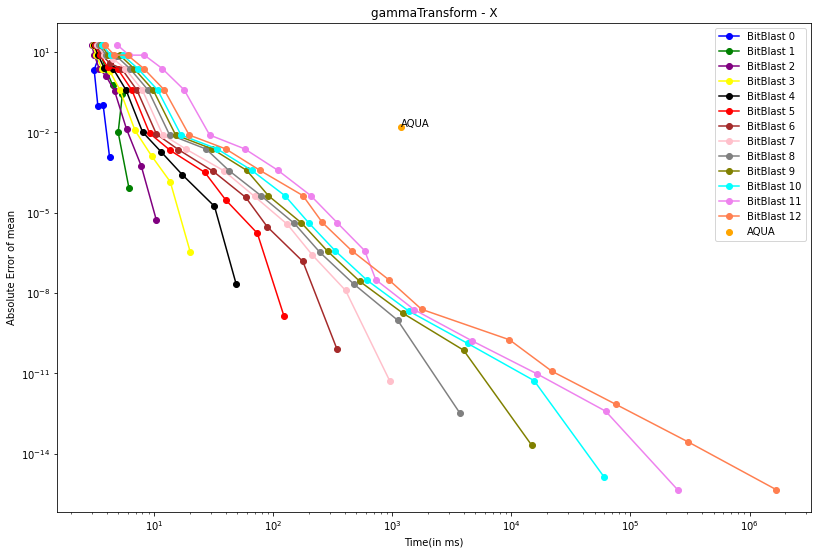

In [36]:
fig, ax = plotting_dice_data('mean', "gammaTransform", "X", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gammaTransform/gammaTransform_res.txt",
                            0, 13, 1/2, gt_mean, AQUA_time, AQUA_mean, False, 'ms')

4.96705032659861e-09 0.1359701251748806


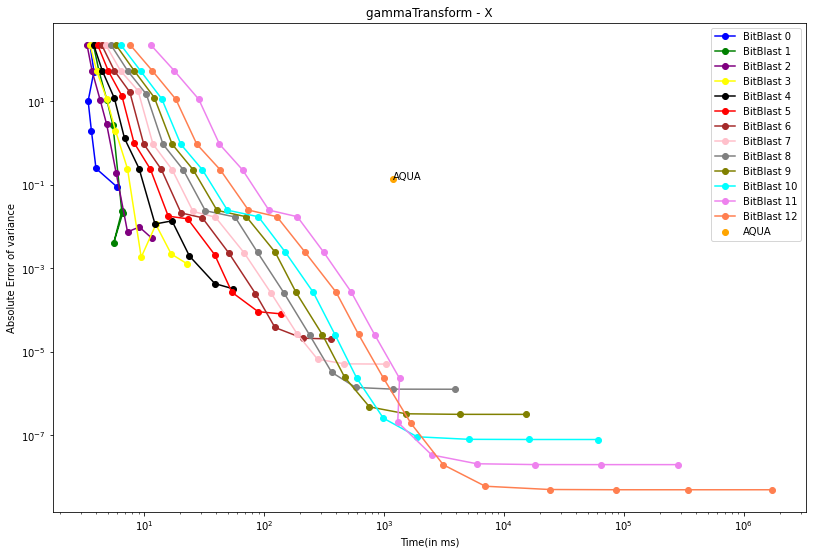

In [37]:
fig, ax = plotting_dice_data('variance', "gammaTransform", "X", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gammaTransform/gammaTransform_res.txt",
                            0, 13, 0, gt_variance, AQUA_time, AQUA_variance, False, 'ms')

Unemployment

1.3633982078586728 0.21266298597476063


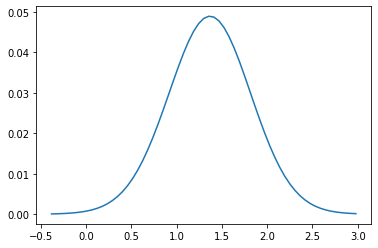

In [38]:
AQUA_beta1_mean, AQUA_beta1_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment/analysis_beta[1].txt")
print(AQUA_beta1_mean, AQUA_beta1_variance)

0.7612193089369887 0.005242902503694413


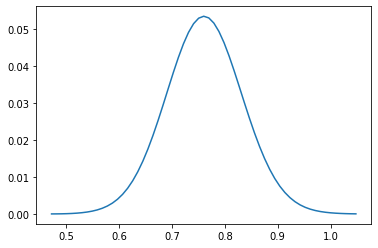

In [39]:
AQUA_beta2_mean, AQUA_beta2_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment/analysis_beta[2].txt")
print(AQUA_beta2_mean, AQUA_beta2_variance)



0.6000000000098802 1.4000000000097221
0.9279411558071368 0.012082611954958189


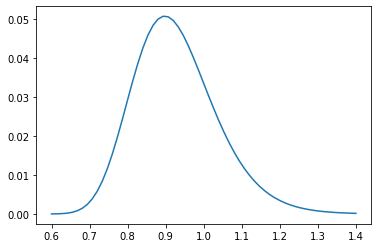

In [39]:
AQUA_sigma_mean, AQUA_sigma_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment/analysis_sigma.txt")
print(AQUA_sigma_mean, AQUA_sigma_variance)

In [41]:
gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/unemployment/results.txt", ['beta[1]', 'beta[2]', 'sigma'])
print(gt_mean, gt_variance)
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment/runtime.txt")
print(AQUA_time)

{'beta[1]': 1.363409828, 'beta[2]': 0.7612146186, 'sigma': 0.928360085} {'beta[1]': 0.2140053728255653, 'beta[2]': 0.005274256728589788, 'sigma': 0.012279079516138264}
4052.838


0.3253647121592316 1.1620141327162159e-05


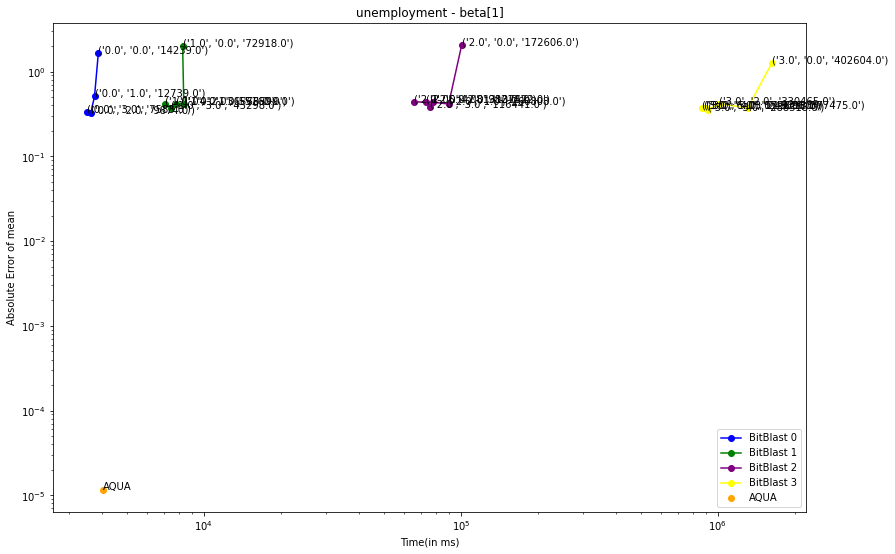

In [42]:
fig, ax = plotting_dice_data('mean', "unemployment", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment/results_0.txt",
                            0, 4, 0.5, gt_mean['beta[1]'], AQUA_time, AQUA_beta1_mean, True, 's')

# plotting_dice_data(mean_or_var, title, var_name, result_file, lowerlimit, upperlimit, offset, gt, AQUA_time, AQUA_val, annot, s_or_ms):

0.7228869022316102 0.0013423868508046777


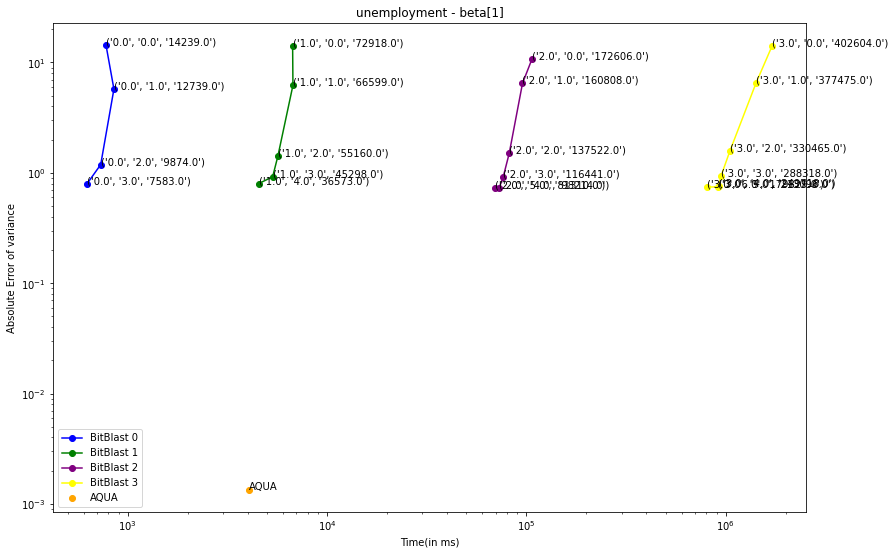

In [43]:
fig, ax = plotting_dice_data('variance', "unemployment", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment/results_0.txt",
                            0, 4, 0, gt_variance['beta[1]'], AQUA_time, AQUA_beta1_variance, True, 's')

0.027447837530673813 4.690336988799615e-06


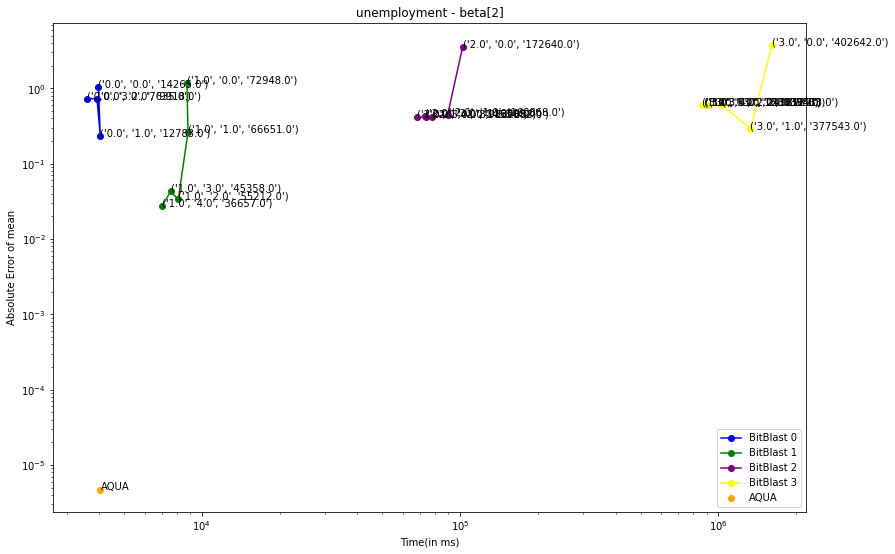

In [44]:
fig, ax = plotting_dice_data('mean', "unemployment", "beta[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment/results_1.txt",
                            0, 4, 0.125, gt_mean['beta[2]'], AQUA_time, AQUA_beta2_mean, True, 's')

0.0008003430479580353 3.135422489537482e-05


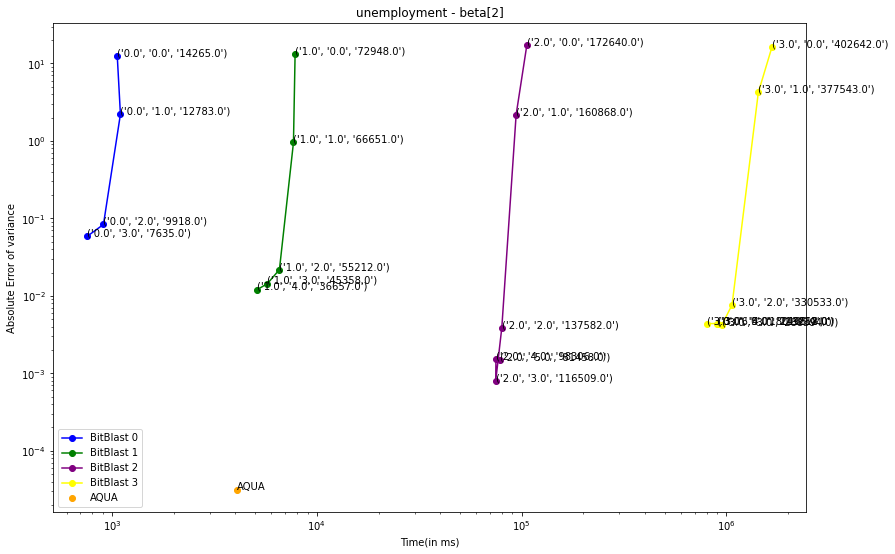

In [45]:
fig, ax = plotting_dice_data('variance', "unemployment", "beta[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment/results_1.txt",
                            0, 4, 0, gt_variance['beta[2]'], AQUA_time, AQUA_beta2_variance, True, 's')

0.13414010135428267 0.0004189291928632377


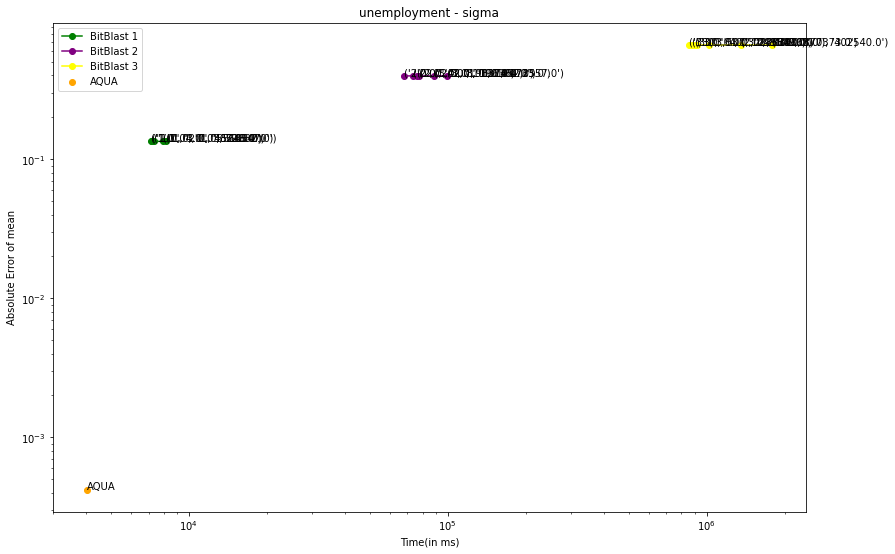

In [46]:
fig, ax = plotting_dice_data('mean', "unemployment", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment/results_2.txt",
                            1, 4, 0.125, gt_mean['sigma'], AQUA_time, AQUA_sigma_mean, True, 's')

0.012121267910174106 0.00019646756118007515


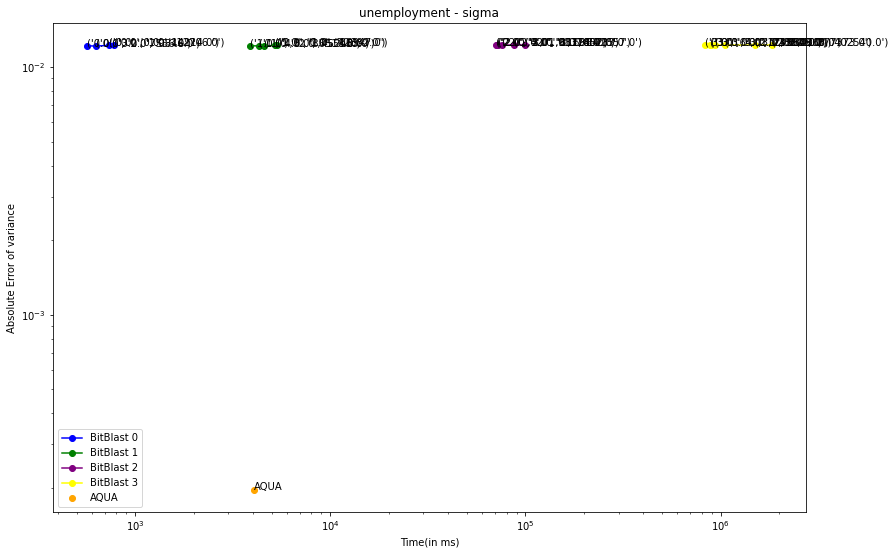

In [47]:
fig, ax = plotting_dice_data('variance', "unemployment", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment/results_2.txt",
                            0, 4, 0, gt_variance['sigma'], AQUA_time, AQUA_sigma_variance, True, 's')

Lightspeed

In [48]:
# Ground Truth

gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/lightspeed/results.txt", ['beta[1]', 'sigma'])
print(gt_mean, gt_variance)

{'beta[1]': 26.55810254, 'sigma': 10.16849644} {'beta[1]': 2.6215027885172244, 'sigma': 1.4455448154179347}


26.55489570478341 2.593720730344785


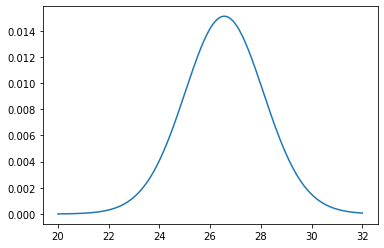

In [49]:
AQUA_beta1_mean, AQUA_beta1_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/lightspeed/analysis_beta[1].txt")
print(AQUA_beta1_mean, AQUA_beta1_variance)

10.164603846944548 1.425886526811695


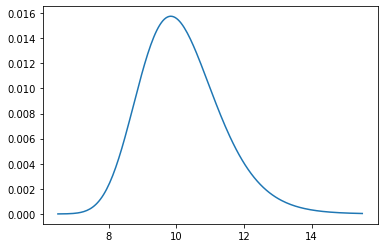

In [50]:
AQUA_sigma_mean, AQUA_sigma_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/lightspeed/analysis_sigma.txt")
print(AQUA_sigma_mean, AQUA_sigma_variance)

In [51]:
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/lightspeed/AQUA_time.txt")
print(AQUA_time)

1710.7849615


0.015013666285142335 0.003206835216591486


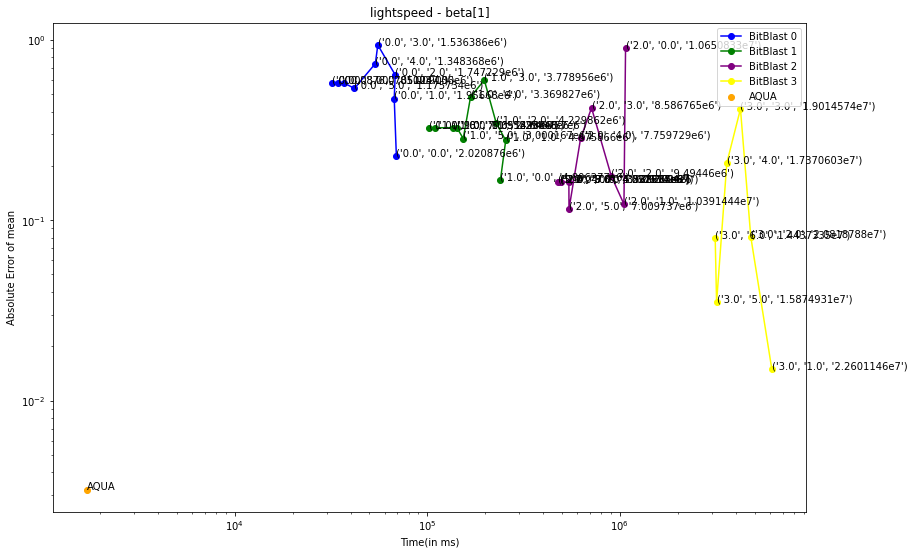

In [52]:
fig, ax = plotting_dice_data('mean', "lightspeed", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/lightspeed/results_0.txt",
                            0, 4, 0.5, gt_mean['beta[1]'], AQUA_time, AQUA_beta1_mean, True, 's')

0.0046879822387020376 0.027782058172439505


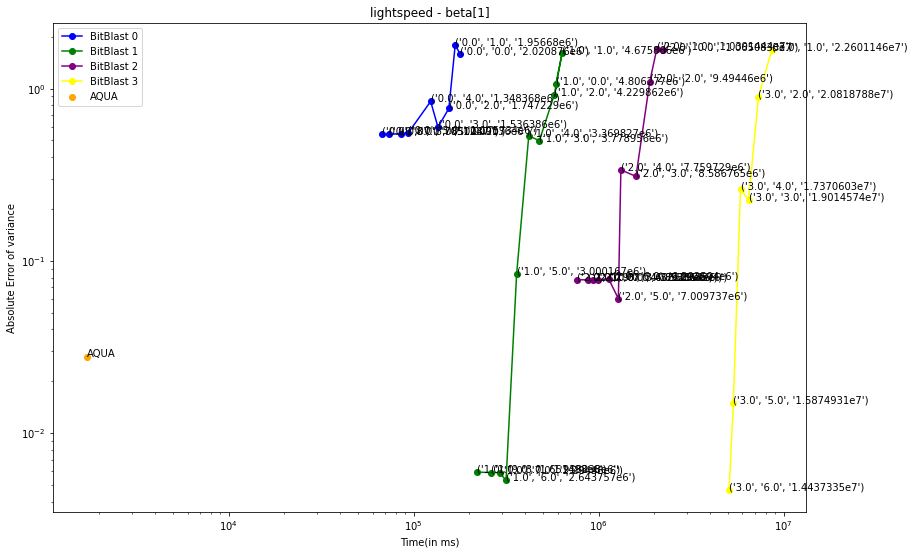

In [53]:
fig, ax = plotting_dice_data('variance', "lightspeed", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/lightspeed/results_0.txt",
                            0, 4, 0, gt_variance['beta[1]'], AQUA_time, AQUA_beta1_variance, True, 's')

0.019890558101060662 0.003892593055452309


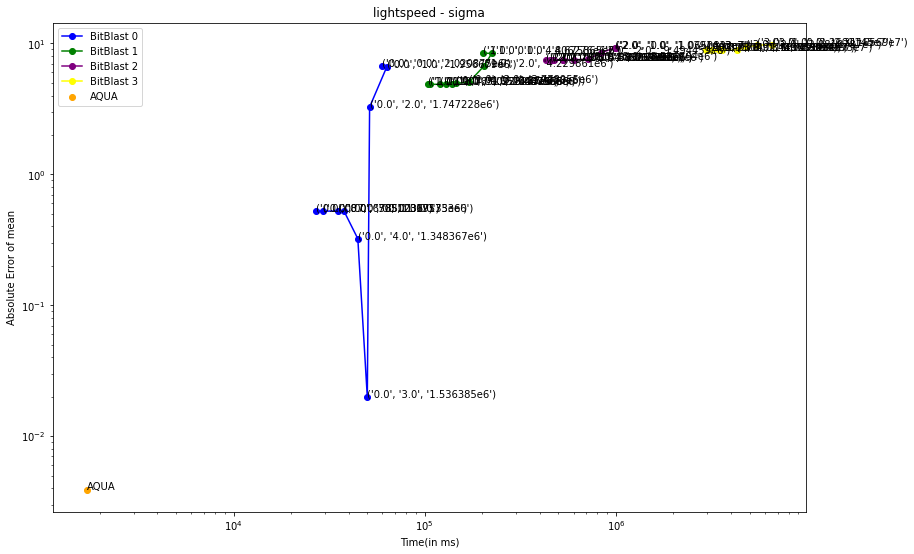

In [54]:
fig, ax = plotting_dice_data('mean', "lightspeed", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/lightspeed/results_1.txt",
                            0, 4, 0.5, gt_mean['sigma'], AQUA_time, AQUA_sigma_mean, True, 's')

0.005112830851037087 0.01965828860623975


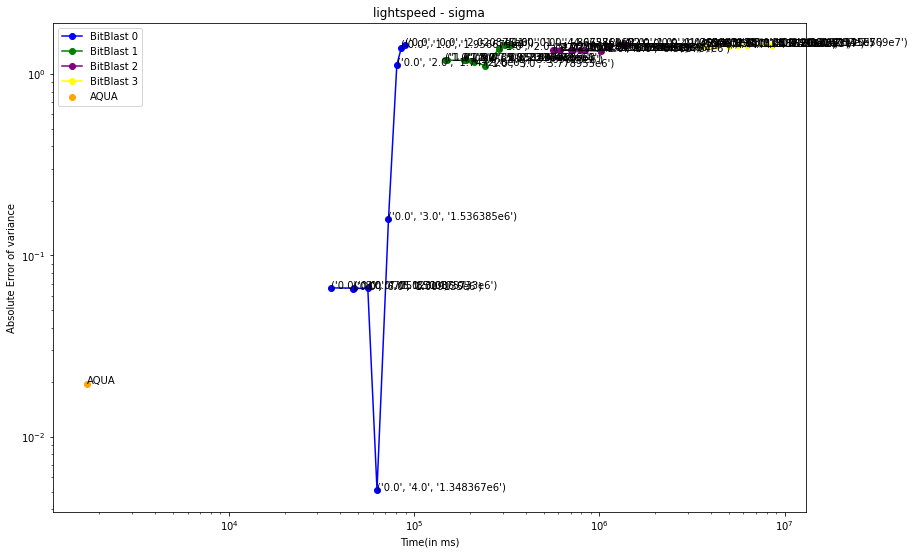

In [55]:
fig, ax = plotting_dice_data('variance', "lightspeed", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/lightspeed/results_1.txt",
                            0, 4, 0, gt_variance['sigma'], AQUA_time, AQUA_sigma_variance, True, 's')

Gaussian Mix Asymmetrical Prior

In [56]:
# Ground Truth

gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/gauss_mix_asym_prior/results.txt", ['mu[1]', 'mu[2]', 'sigma[1]', 'sigma[2]'])
print(gt_mean, gt_variance)

{'mu[1]': 3.116300064, 'mu[2]': -2.647339929, 'sigma[1]': 1.173677251, 'sigma[2]': 0.9703079802} {'mu[1]': 0.079054253538237, 'mu[2]': 0.031102415650097637, 'sigma[1]': 0.09391663987006868, 'sigma[2]': 0.021148130846967345}


{'mu[1]': 3.1182287323577937, 'mu[2]': -2.647822656330139, 'sigma[1]': 1.1663995969213024, 'sigma[2]': 0.96920807514984} {'mu[1]': 0.07560977935857771, 'mu[2]': 0.030588407505567794, 'sigma[1]': 0.08270820423868086, 'sigma[2]': 0.02041806741931773}


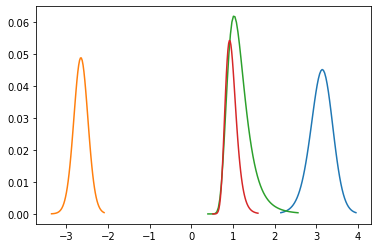

In [57]:
AQUA_mean, AQUA_variance = {}, {}
vars = ['mu[1]', 'mu[2]', 'sigma[1]', 'sigma[2]']
for i in vars:
    # print(i)
    AQUA_mean[i], AQUA_variance[i] = read_AQUA_file(f"/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/gauss_mix_asym_prior/analysis_{i}.txt")
print(AQUA_mean, AQUA_variance)

In [58]:
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/gauss_mix_asym_prior/AQUA_time.txt")
print(AQUA_time)

100954.941406


0.29243055077841484 0.0019286683577939279


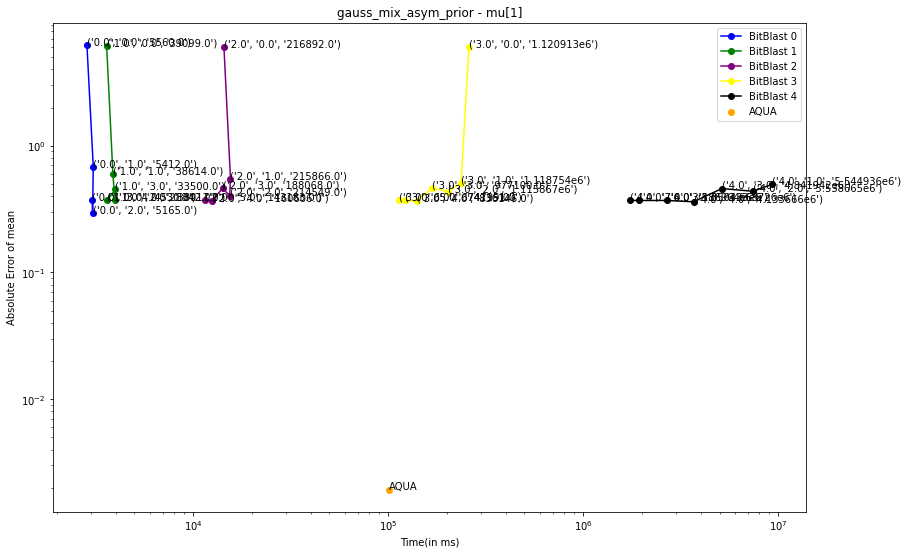

In [59]:
fig, ax = plotting_dice_data('mean', "gauss_mix_asym_prior", "mu[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior/results_0.txt",
                            0, 5, 0.5, gt_mean['mu[1]'], AQUA_time, AQUA_mean['mu[1]'], True, 's')

0.17128631751433895 0.0034444741796592904


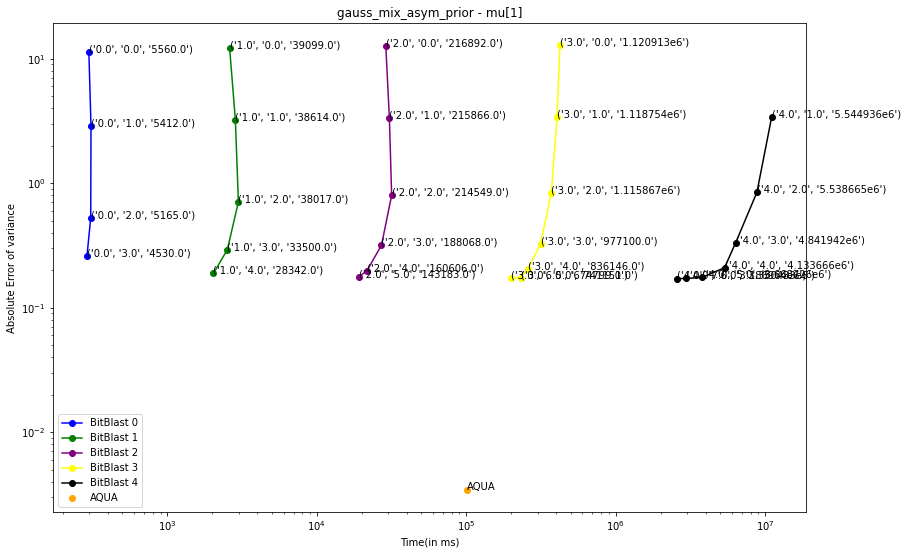

In [60]:
fig, ax = plotting_dice_data('variance', "gauss_mix_asym_prior", "mu[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior/results_0.txt",
                            0, 5, 0, gt_variance['mu[1]'], AQUA_time, AQUA_variance['mu[1]'], True, 's')

0.0997626445765123 0.00048272733013865476


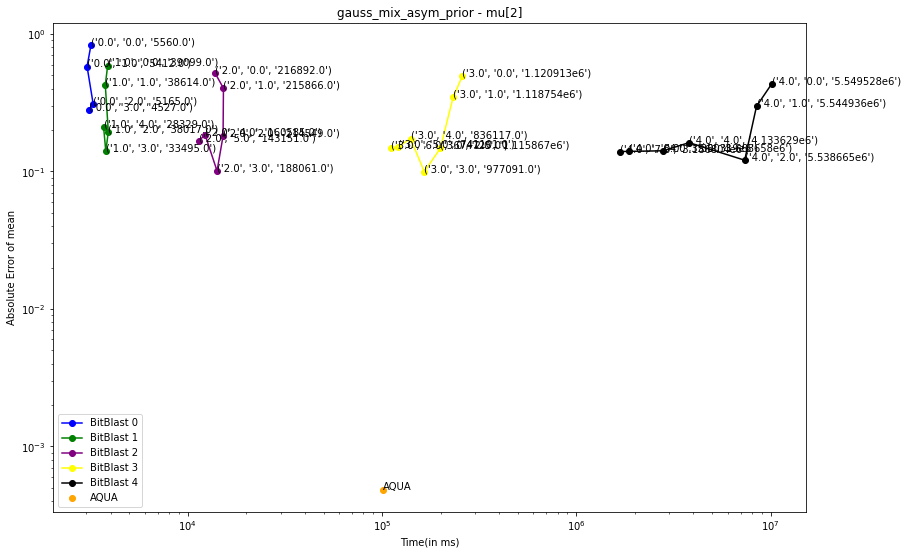

In [61]:
fig, ax = plotting_dice_data('mean', "gauss_mix_asym_prior", "mu[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior/results_1.txt",
                            0, 5, 0.5, gt_mean['mu[2]'], AQUA_time, AQUA_mean['mu[2]'], True, 's')

0.22456848662362444 0.0005140081445298428


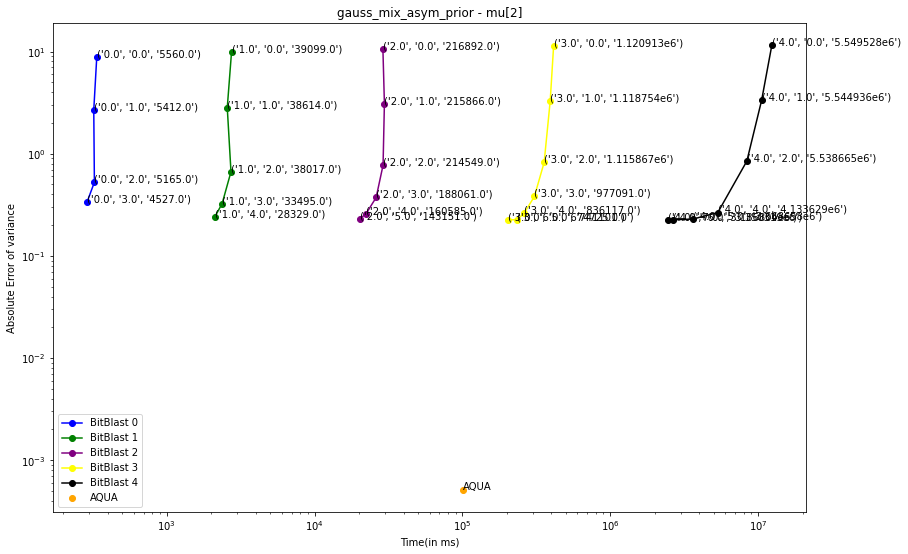

In [62]:
fig, ax = plotting_dice_data('variance', "gauss_mix_asym_prior", "mu[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior/results_1.txt",
                            0, 5, 0, gt_variance['mu[2]'], AQUA_time, AQUA_variance['mu[2]'], True, 's')

0.4558948323901688 0.007277654078697626


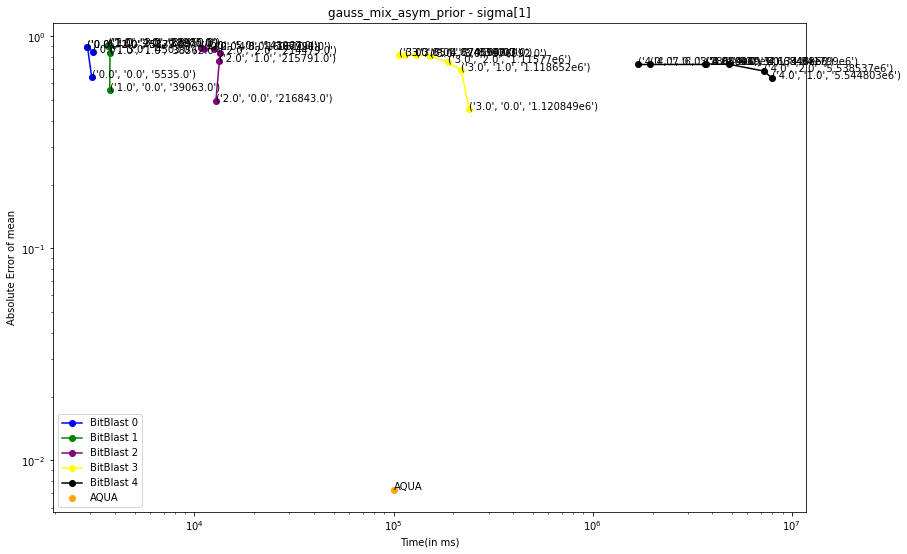

In [63]:
fig, ax = plotting_dice_data('mean', "gauss_mix_asym_prior", "sigma[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior/results_2.txt",
                            0, 5, 0.5, gt_mean['sigma[1]'], AQUA_time, AQUA_mean['sigma[1]'], True, 's')

1.1096836857605352 0.01120843563138782


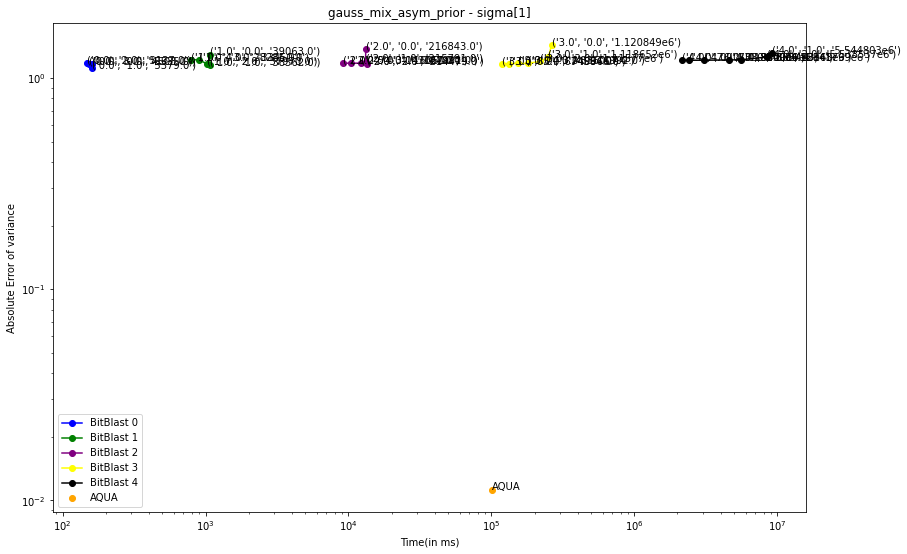

In [64]:
fig, ax = plotting_dice_data('variance', "gauss_mix_asym_prior", "sigma[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior/results_2.txt",
                            0, 5, 0, gt_variance['sigma[1]'], AQUA_time, AQUA_variance['sigma[1]'], True, 's')

0.07098957937635386 0.0010999050501599994


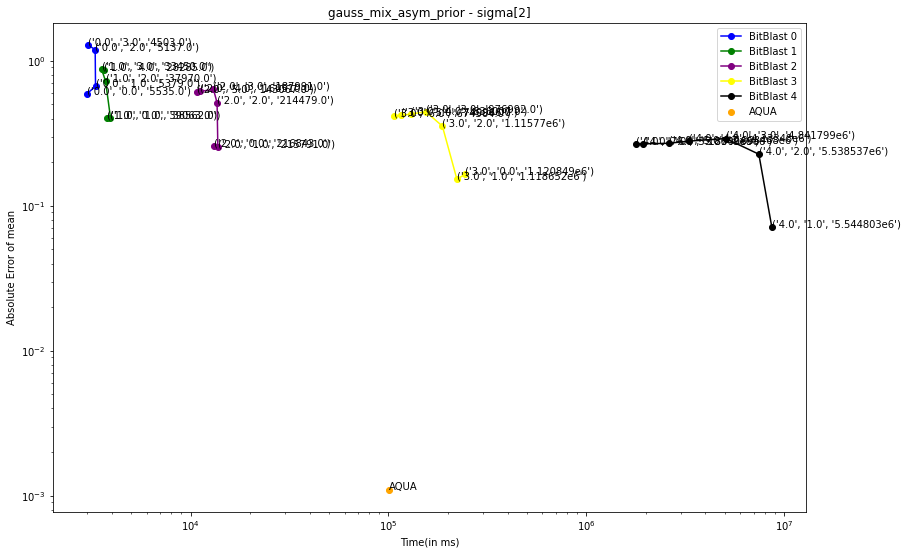

In [65]:
fig, ax = plotting_dice_data('mean', "gauss_mix_asym_prior", "sigma[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior/results_3.txt",
                            0, 5, 0.5, gt_mean['sigma[2]'], AQUA_time, AQUA_mean['sigma[2]'], True, 's')

0.6270734292861425 0.0007300634276496132


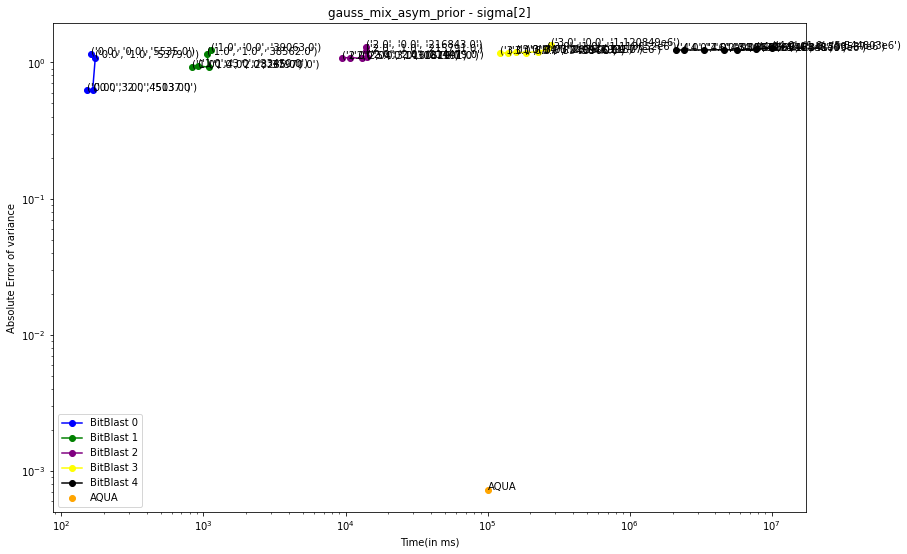

In [66]:
fig, ax = plotting_dice_data('variance', "gauss_mix_asym_prior", "sigma[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/gauss_mix_asym_prior/results_3.txt",
                            0, 5, 0, gt_variance['sigma[2]'], AQUA_time, AQUA_variance['sigma[2]'], True, 's')

Normal_Mixture

In [67]:
# Ground Truth

gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/normal_mixture/results.txt", ['mu[1]', 'mu[2]', 'theta'])
print(gt_mean, gt_variance)

{'mu[1]': -5.028920059, 'mu[2]': 5.234615871, 'theta': 0.3928551869} {'mu[1]': 65.59366153529413, 'mu[2]': 58.74543290255279, 'theta': 0.03918052796111996}


{'mu[1]': -9.702495057285518, 'mu[2]': 9.657766163084034, 'theta': 0.2857243052496571} {'mu[1]': 0.08310954682160343, 'mu[2]': 0.03298641322834328, 'theta': 0.004718640093064927}


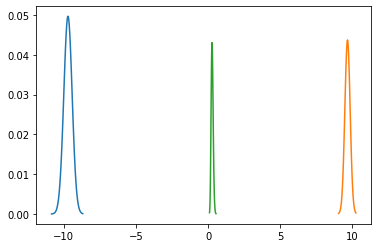

In [68]:
AQUA_mean, AQUA_variance = {}, {}
vars = ['mu[1]', 'mu[2]', 'theta']
for i in vars:
    # print(i)
    AQUA_mean[i], AQUA_variance[i] = read_AQUA_file(f"/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/normal_mixture/analysis_{i}.txt")
print(AQUA_mean, AQUA_variance)

0.04694614694146493 0.1071308816503429


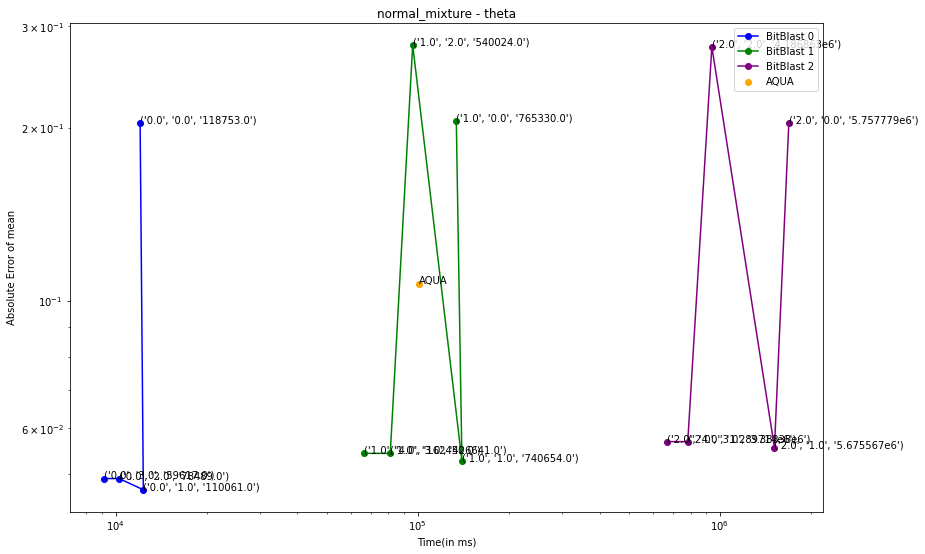

In [69]:
fig, ax = plotting_dice_data('mean', "normal_mixture", "theta", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_0.txt",
                            0, 3, 1/32, gt_mean['theta'], AQUA_time, AQUA_mean['theta'], True, 's')


0.01474955816908094 0.034461887868055034


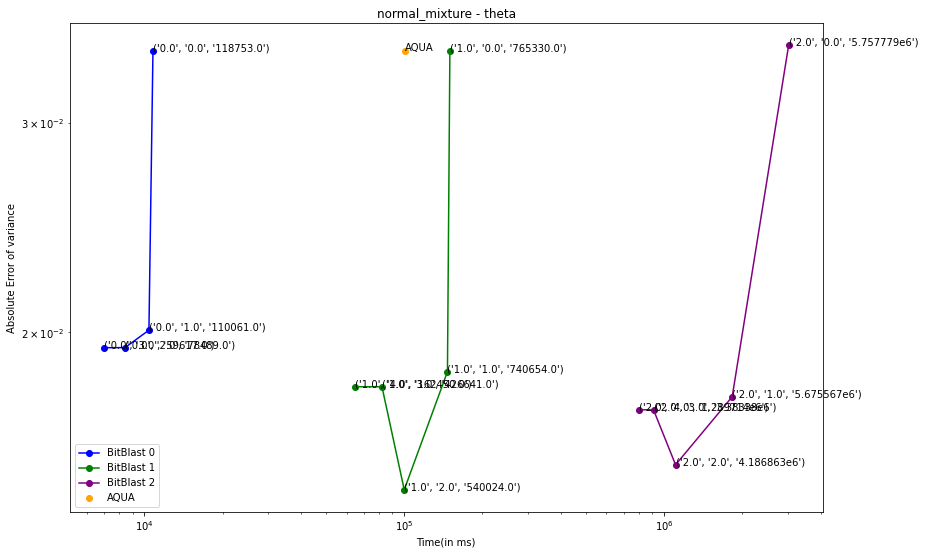

In [70]:
fig, ax = plotting_dice_data('variance', "normal_mixture", "theta", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_0.txt",
                            0, 3, 0, gt_variance['theta'], AQUA_time, AQUA_variance['theta'], True, 's')

2.9110381228019877 4.673574998285518


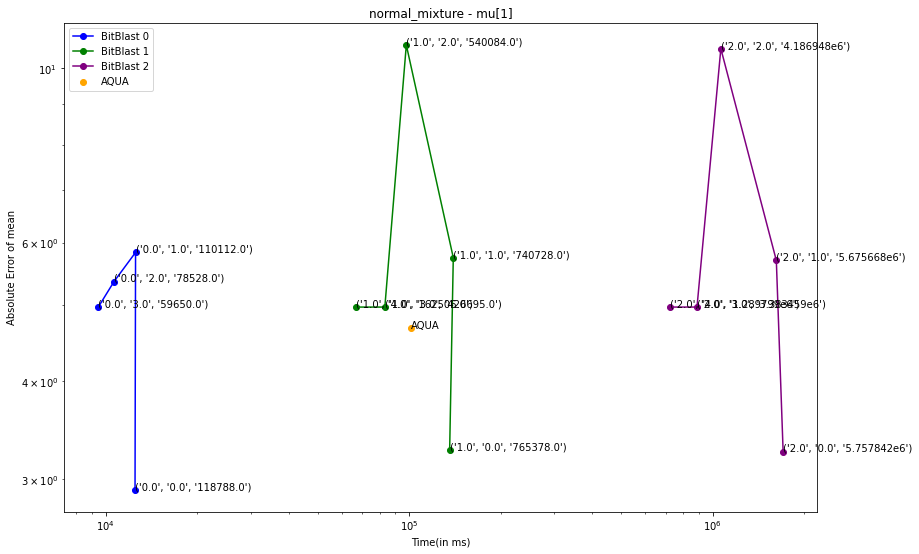

In [71]:
fig, ax = plotting_dice_data('mean', "normal_mixture", "mu[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_1.txt",
                            0, 3, 1/2, gt_mean['mu[1]'], AQUA_time, AQUA_mean['mu[1]'], True, 's')

50.23628438949954 65.51055198847253


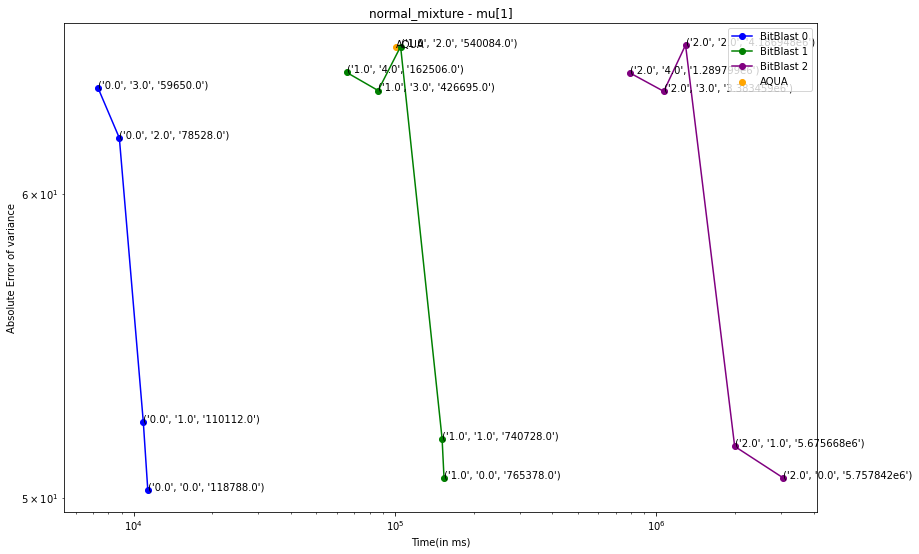

In [72]:
fig, ax = plotting_dice_data('variance', "normal_mixture", "mu[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_1.txt",
                            0, 3, 0, gt_variance['mu[1]'], AQUA_time, AQUA_variance['mu[1]'], True, 's')

3.0176345606257424 4.423150292084034


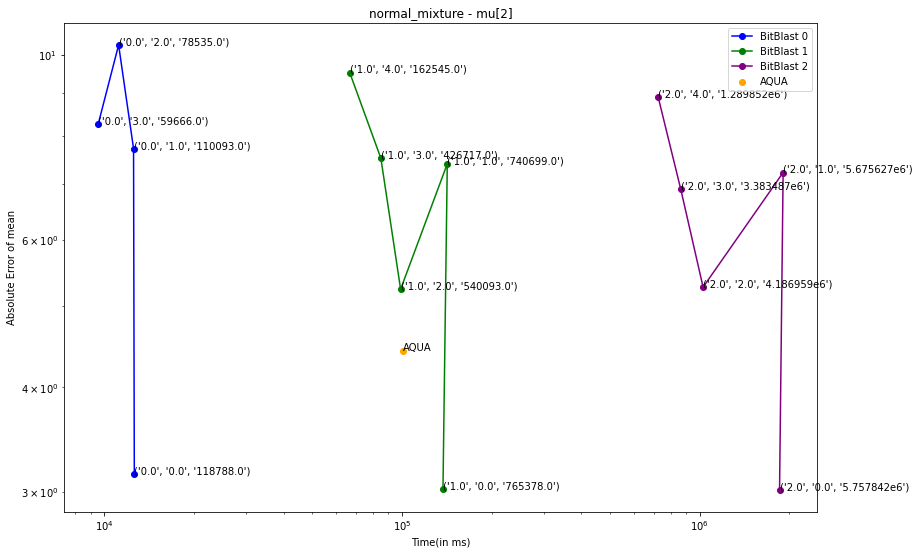

In [73]:
fig, ax = plotting_dice_data('mean', "normal_mixture", "mu[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_2.txt",
                            0, 3, 1/2, gt_mean['mu[2]'], AQUA_time, AQUA_mean['mu[2]'], True, 's')

19.795246268556582 58.71244648932445


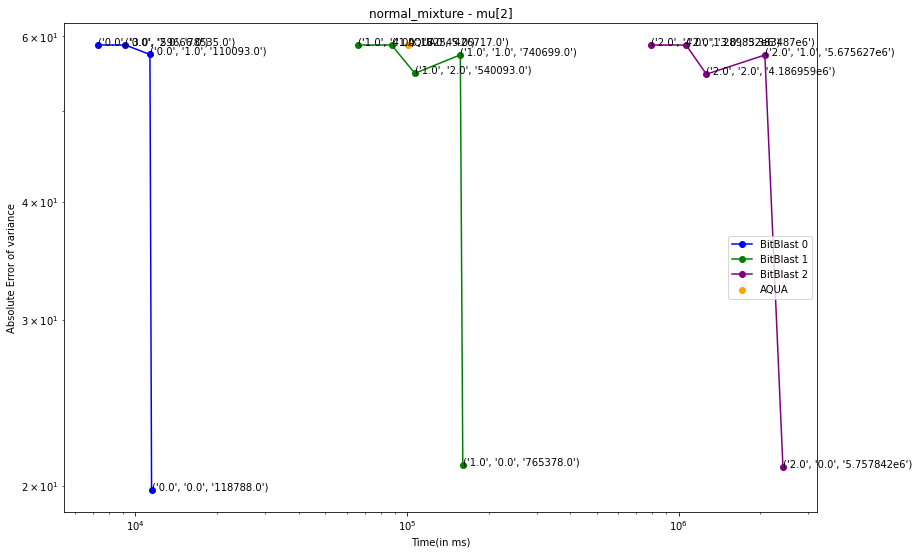

In [74]:
fig, ax = plotting_dice_data('variance', "normal_mixture", "mu[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/normal_mixture/results_2.txt",
                            0, 3, 0, gt_variance['mu[2]'], AQUA_time, AQUA_variance['mu[2]'], True, 's')

Timeseries

In [75]:
# Ground Truth

gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/timeseries/results.txt", ['alpha', 'beta', 'lambda'])
print(gt_mean, gt_variance)

{'alpha': -1.576438438, 'beta': 0.6838821225, 'lambda': 0.4761626538} {'alpha': 0.08718596305430863, 'beta': 0.007727501118365029, 'lambda': 0.009083154147157666}


{'alpha': -1.5752270953520866, 'beta': 0.6840096410299795, 'lambda': 0.4765680957849794} {'alpha': 0.08564906735148714, 'beta': 0.00771888126303194, 'lambda': 0.008911417608545469}


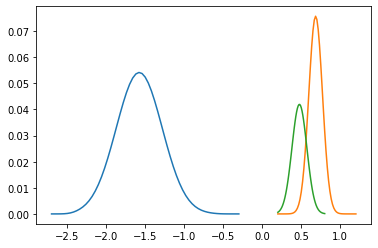

In [76]:
AQUA_mean, AQUA_variance = {}, {}
vars = ['alpha', 'beta', 'lambda']
for i in vars:
    # print(i)
    AQUA_mean[i], AQUA_variance[i] = read_AQUA_file(f"/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/timeseries/analysis_{i}.txt")
print(AQUA_mean, AQUA_variance)

1.1735615756329258 0.0012113426479134493


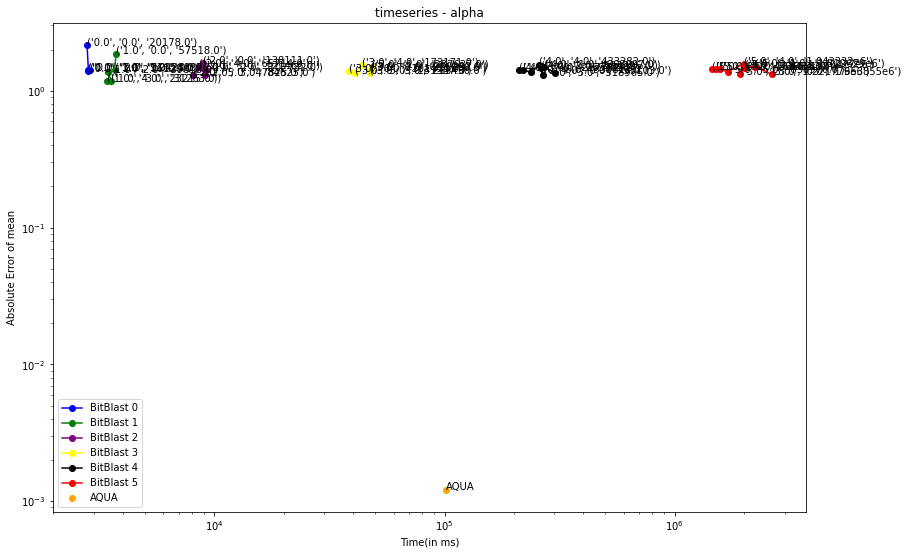

In [77]:
fig, ax = plotting_dice_data('mean', "timeseries", "alpha", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries/results_0.txt",
                            0, 6, 1/2, gt_mean['alpha'], AQUA_time, AQUA_mean['alpha'], True, 's')

1.1735615756329258 0.0012113426479134493


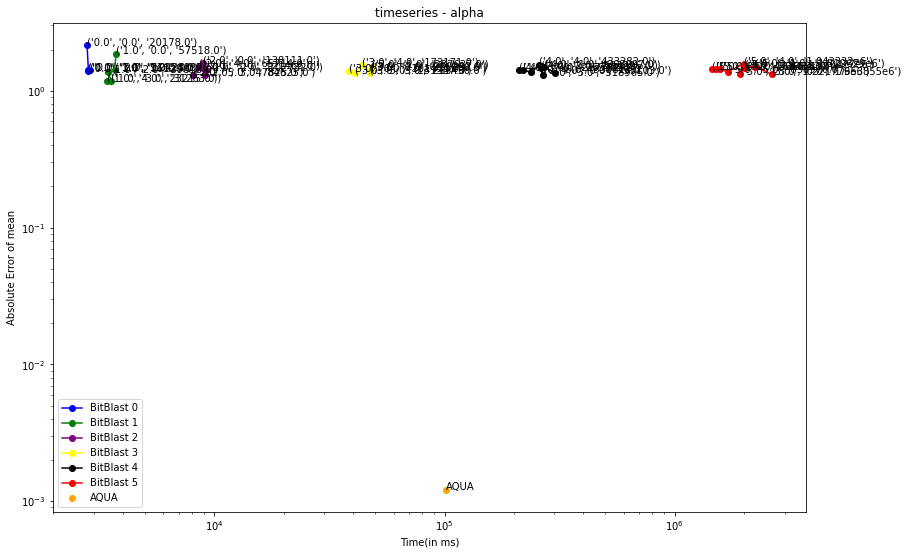

In [78]:
fig, ax = plotting_dice_data('mean', "timeseries", "alpha", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries/results_0.txt",
                            0, 6, 1/2, gt_mean['alpha'], AQUA_time, AQUA_mean['alpha'], True, 's')

0.0006724763106993742 0.001536895702821492


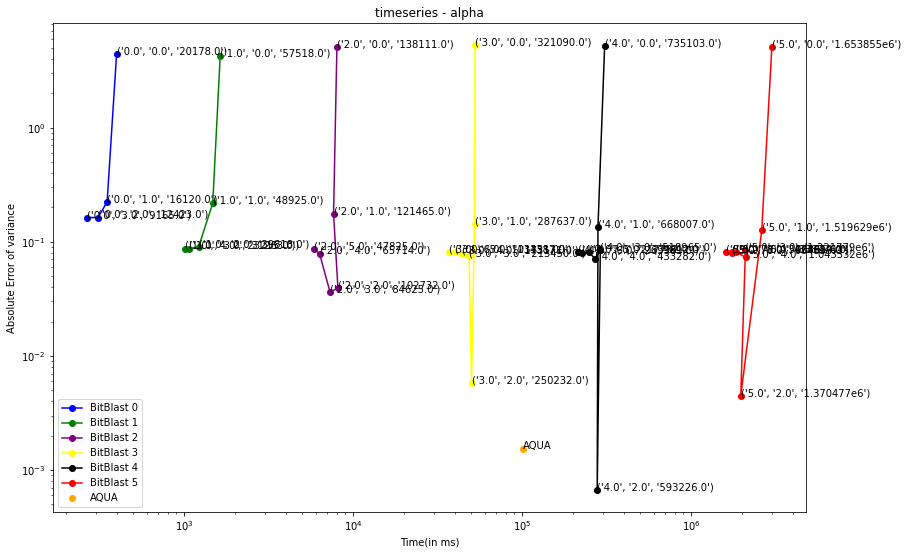

In [79]:
fig, ax = plotting_dice_data('variance', "timeseries", "alpha", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries/results_0.txt",
                            0, 6, 0, gt_variance['alpha'], AQUA_time, AQUA_variance['alpha'], True, 's')

0.43388205227436305 0.00012751852997949786


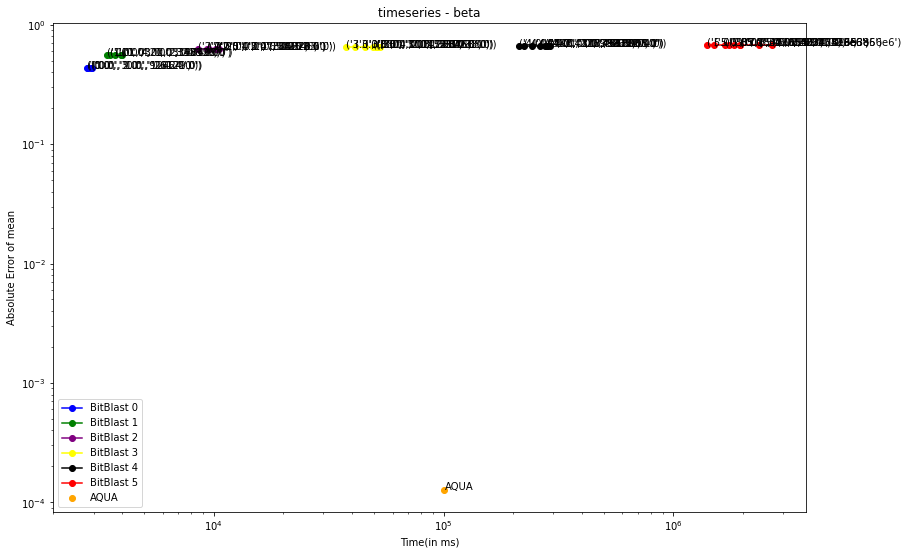

In [80]:
fig, ax = plotting_dice_data('mean', "timeseries", "beta", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries/results_1.txt",
                            0, 6, 1/4, gt_mean['beta'], AQUA_time, AQUA_mean['beta'], True, 's')

0.007727208104595686 8.619855333088719e-06


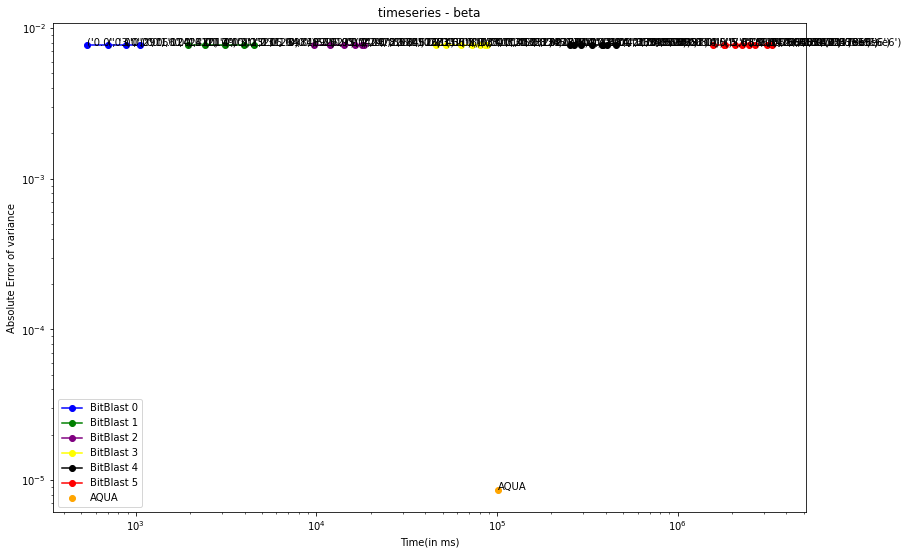

In [81]:
fig, ax = plotting_dice_data('variance', "timeseries", "beta", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries/results_1.txt",
                            0, 6, 0, gt_variance['beta'], AQUA_time, AQUA_variance['beta'], True, 's')

0.1537811250584894 0.0004054419849793822


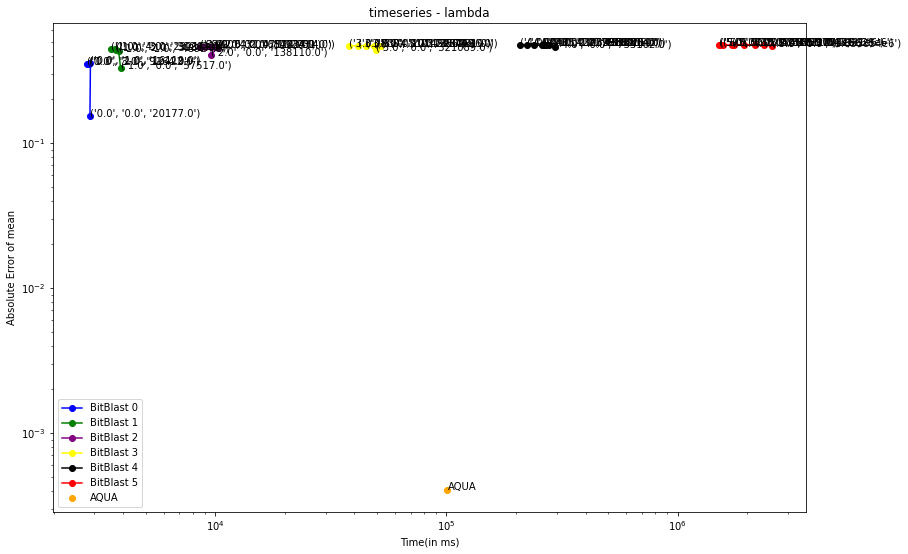

In [82]:
fig, ax = plotting_dice_data('mean', "timeseries", "lambda", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries/results_2.txt",
                            0, 6, 1/16, gt_mean['lambda'], AQUA_time, AQUA_mean['lambda'], True, 's')

0.0022957111689307693 0.00017173653861219697


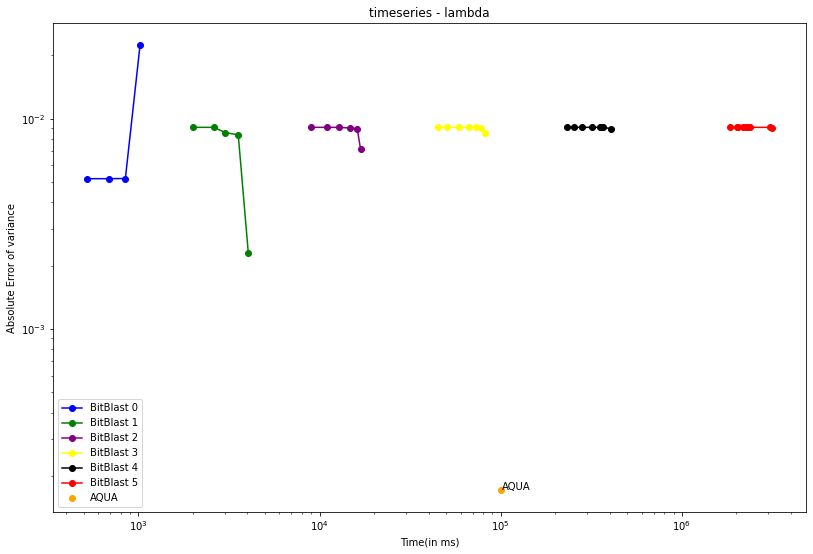

In [83]:
fig, ax = plotting_dice_data('variance', "timeseries", "lambda", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/timeseries/results_2.txt",
                            0, 6, 0, gt_variance['lambda'], AQUA_time, AQUA_variance['lambda'], False, 's')

Unemployment_5

1.3284980685423304 0.8650436277728923


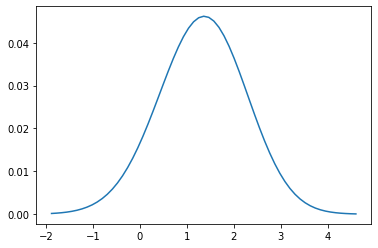

In [25]:
AQUA_beta1_mean, AQUA_beta1_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_5/analysis_beta[1].txt")
print(AQUA_beta1_mean, AQUA_beta1_variance)

0.7071301653245889 0.04887100594148075


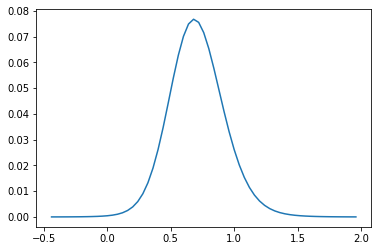

In [26]:
AQUA_beta2_mean, AQUA_beta2_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_5/analysis_beta[2].txt")
print(AQUA_beta2_mean, AQUA_beta2_variance)



1e-11 6.000000000008805
1.552277816519795 0.6940600359165652


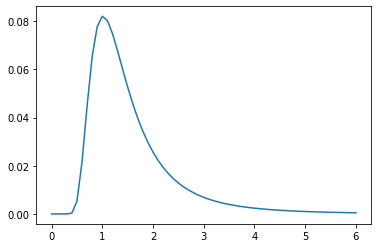

In [38]:
AQUA_sigma_mean, AQUA_sigma_variance = read_AQUA_file("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_5/analysis_sigma.txt")
print(AQUA_sigma_mean, AQUA_sigma_variance)

In [10]:
gt_mean, gt_variance = gt_from_sampling("/home/poorvagarg/cmdstan-2.28.2/benchmarks/unemployment_5/results.txt", ['beta[1]', 'beta[2]', 'sigma'])
print(gt_mean, gt_variance)
AQUA_time = read_AQUA_time("/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/unemployment_5/AQUA_time.txt")
print(AQUA_time)

{'beta[1]': 1.324379118, 'beta[2]': 0.7085033127, 'sigma': 1.613857191} {'beta[1]': 0.8724381647938275, 'beta[2]': 0.05189122008128229, 'sigma': 1.2149735891886273}
1170.264915


0.2693067572702357 0.004118950542330468


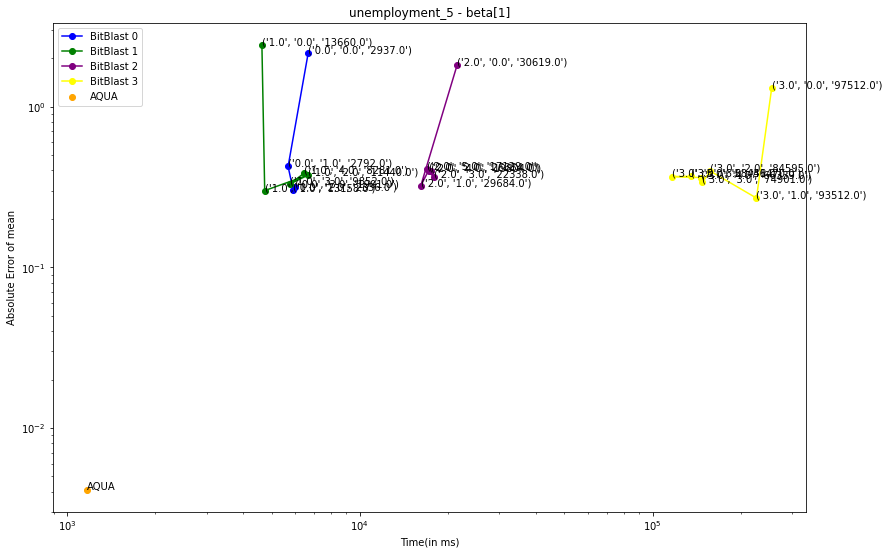

In [31]:
fig, ax = plotting_dice_data('mean', "unemployment_5", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_0.txt",
                            0, 4, 0.5, gt_mean['beta[1]'], AQUA_time, AQUA_beta1_mean, True, 's')

# plotting_dice_data(mean_or_var, title, var_name, result_file, lowerlimit, upperlimit, offset, gt, AQUA_time, AQUA_val, annot, s_or_ms):

0.11481377268695048 0.007394537020935177


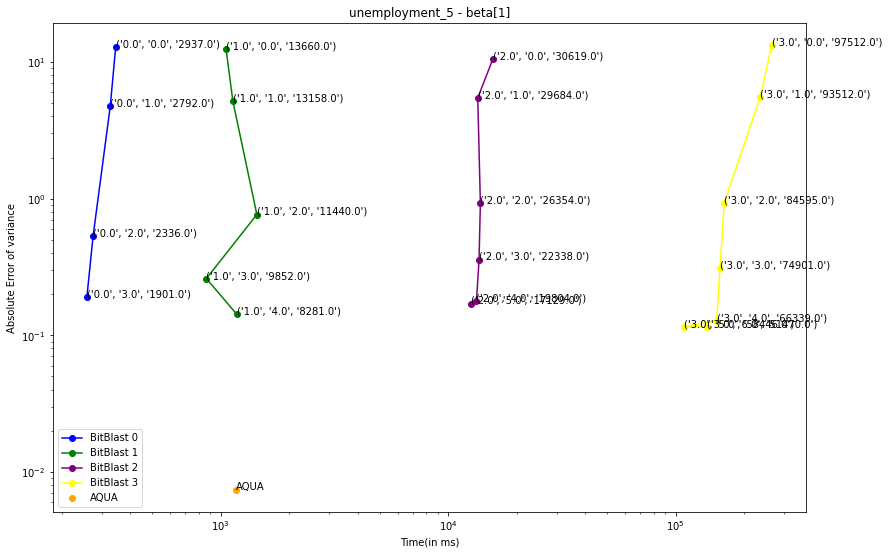

In [32]:
fig, ax = plotting_dice_data('variance', "unemployment_5", "beta[1]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_0.txt",
                            0, 4, 0, gt_variance['beta[1]'], AQUA_time, AQUA_beta1_variance, True, 's')

0.09568911043340644 0.0013731473754110546


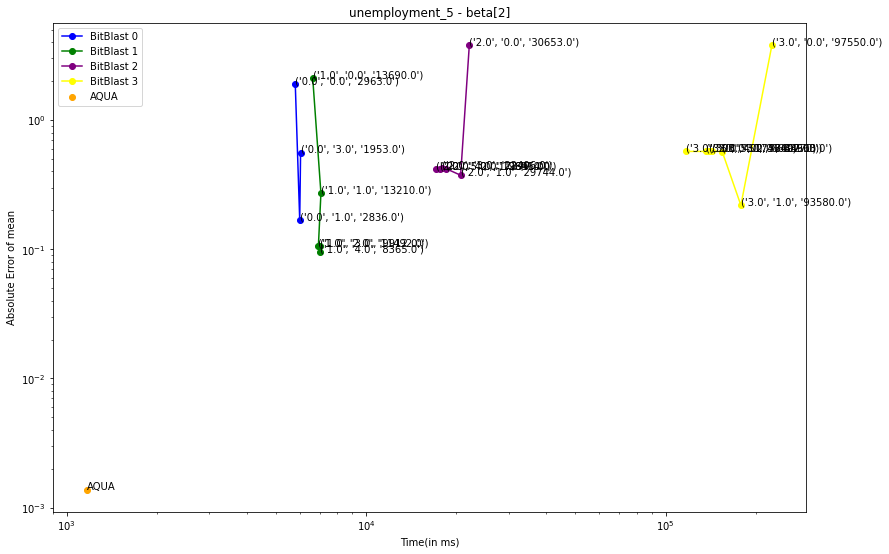

In [33]:
fig, ax = plotting_dice_data('mean', "unemployment_5", "beta[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_1.txt",
                            0, 4, 0.125, gt_mean['beta[2]'], AQUA_time, AQUA_beta2_mean, True, 's')

0.017345148605239807 0.0030202141398015386


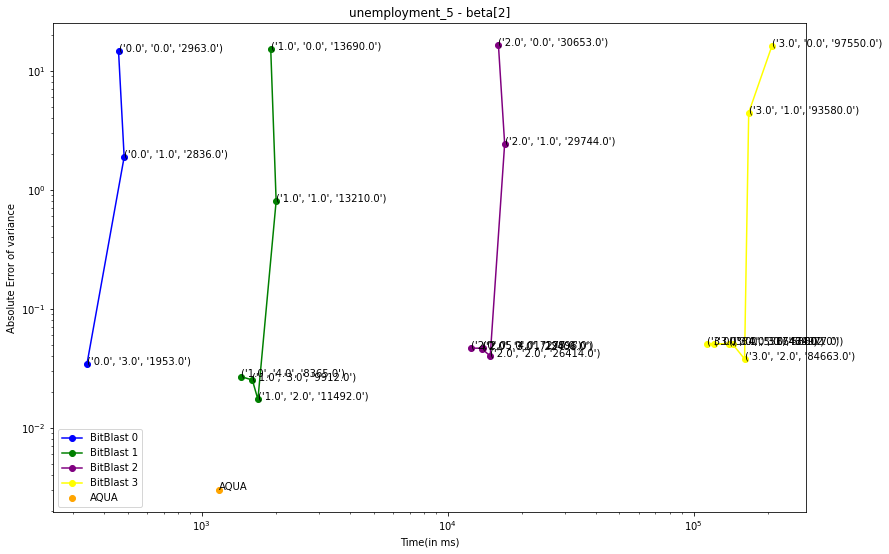

In [34]:
fig, ax = plotting_dice_data('variance', "unemployment_5", "beta[2]", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_1.txt",
                            0, 4, 0, gt_variance['beta[2]'], AQUA_time, AQUA_beta2_variance, True, 's')

0.21079201304406037 0.061579374480204896


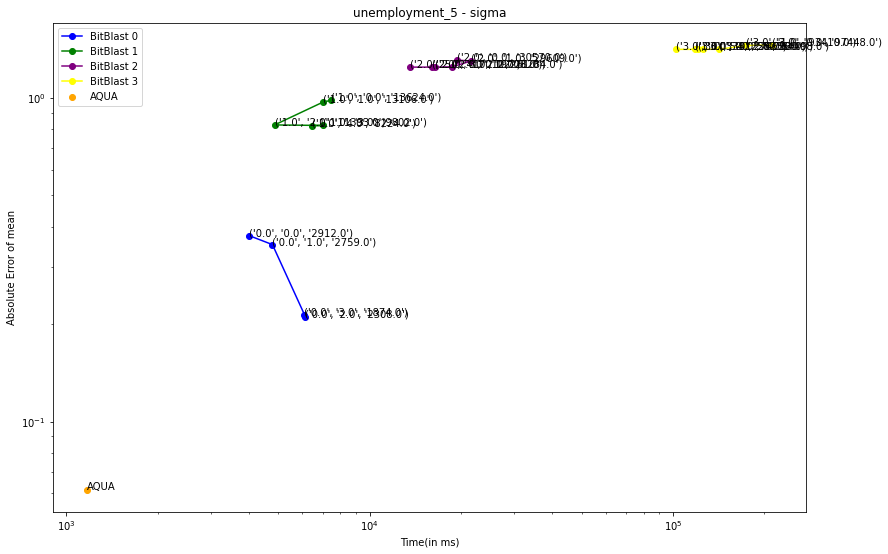

In [35]:
fig, ax = plotting_dice_data('mean', "unemployment_5", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_2.txt",
                            0, 4, 0.125, gt_mean['sigma'], AQUA_time, AQUA_sigma_mean, True, 's')

0.8935201029966602 0.5209135532720621


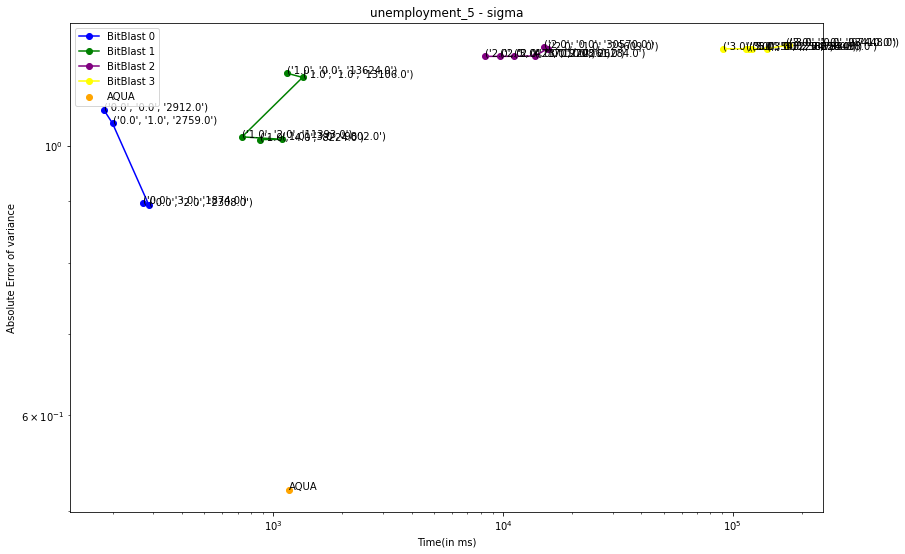

In [36]:
fig, ax = plotting_dice_data('variance', "unemployment_5", "sigma", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/unemployment_5/results_2.txt",
                            0, 4, 0, gt_variance['sigma'], AQUA_time, AQUA_sigma_variance, True, 's')

Zeroone

In [53]:
# Ground Truth
gt_mean, gt_variance = {}, {}
gt_mean['w1'] = 0.0565823032448
gt_variance['w1'] = 18.2304754051

gt_mean['w2'] = 3.68882559517
gt_variance['w2'] = 13.1973498958

-8.0 8.00000000000001
-8.0 8.00000000000001
{'w1': -0.039999999999992895, 'w2': -0.039999999999992895} {'w1': 21.332800000000024, 'w2': 21.332800000000024}


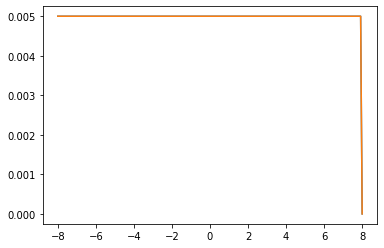

In [54]:
AQUA_mean, AQUA_variance = {}, {}
vars = ['w1', 'w2']
for i in vars:
    # print(i)
    AQUA_mean[i], AQUA_variance[i] = read_AQUA_file(f"/home/poorvagarg/Desktop/AQUA/benchmarks/stan_bench/zeroone/analysis_{i}.txt")
print(AQUA_mean, AQUA_variance)

['0.0,0.0,32.0,570.0,2.491127793,0.9707410933906928,0.173015232,15.542657786512066\n', '1.0,0.0,35.0,1805.0,3.528126637,0.8830024143044968,0.512015879,16.115191334621976\n', '2.0,0.0,38.0,5697.0,3.610755742,0.863901046549377,1.25770011,16.256073218587034\n', '3.0,0.0,41.0,19805.0,2.939074445,0.28099839048067654,2.355752683,17.93422210879102\n', '4.0,0.0,44.0,47200.0,6.034474067,0.08807179530736864,11.257331017,18.19838685759482\n', '5.0,0.0,47.0,99228.0,7.596690918,0.08945132408338186,15.871075422,18.202003123412737\n', '6.0,0.0,50.0,216528.0,17.519396488,0.08990485690824812,67.965228893,18.2034935096301\n', '7.0,0.0,53.0,459572.0,38.022211417,0.06887273537811645,182.294029074,18.220985961377586\n', '8.0,0.0,56.0,987528.0,73.946849199,0.05857515218357534,278.251458202,18.228753237665778\n', '9.0,0.0,59.0,2.084272e6,143.660137651,0.05860810642524594,968.86046041,18.228908999460792\n', '10.0,0.0,62.0,4.575074e6,430.761678374,0.05862369410721513,2225.523028352,18.228985518829553\n']
0.970

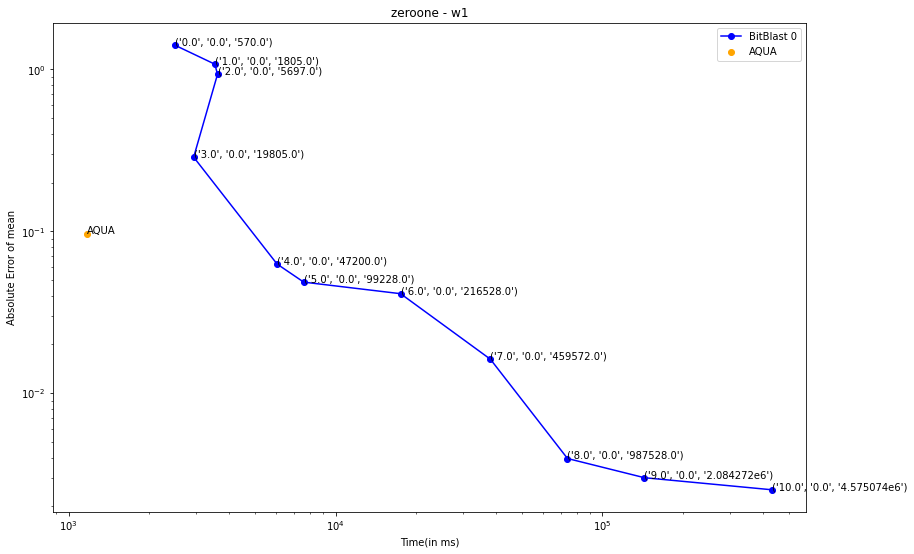

In [77]:
fig, ax = plotting_dice_bits('mean', "zeroone", "w1", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/zeroone/results_0.txt",
                            0, 1, 0.5, gt_mean['w1'], AQUA_time, AQUA_mean['w1'], True, 's')

# plotting_dice_data(mean_or_var, title, var_name, result_file, lowerlimit, upperlimit, offset, gt, AQUA_time, AQUA_val, annot, s_or_ms):

['0.0,0.0,32.0,570.0,2.491127793,0.9707410933906928,0.173015232,15.542657786512066\n', '1.0,0.0,35.0,1805.0,3.528126637,0.8830024143044968,0.512015879,16.115191334621976\n', '2.0,0.0,38.0,5697.0,3.610755742,0.863901046549377,1.25770011,16.256073218587034\n', '3.0,0.0,41.0,19805.0,2.939074445,0.28099839048067654,2.355752683,17.93422210879102\n', '4.0,0.0,44.0,47200.0,6.034474067,0.08807179530736864,11.257331017,18.19838685759482\n', '5.0,0.0,47.0,99228.0,7.596690918,0.08945132408338186,15.871075422,18.202003123412737\n', '6.0,0.0,50.0,216528.0,17.519396488,0.08990485690824812,67.965228893,18.2034935096301\n', '7.0,0.0,53.0,459572.0,38.022211417,0.06887273537811645,182.294029074,18.220985961377586\n', '8.0,0.0,56.0,987528.0,73.946849199,0.05857515218357534,278.251458202,18.228753237665778\n', '9.0,0.0,59.0,2.084272e6,143.660137651,0.05860810642524594,968.86046041,18.228908999460792\n', '10.0,0.0,62.0,4.575074e6,430.761678374,0.05862369410721513,2225.523028352,18.228985518829553\n']
0.970

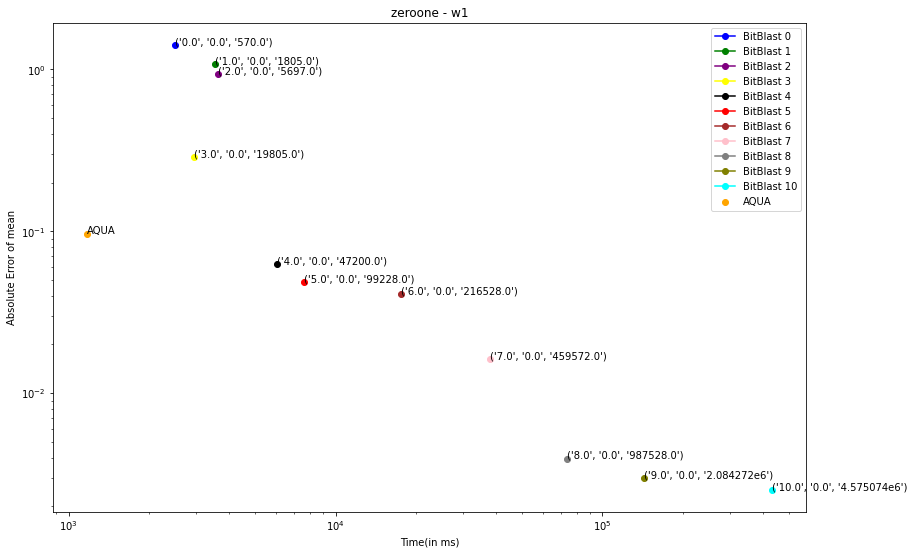

In [73]:
fig, ax = plotting_dice_data('mean', "zeroone", "w1", 
                            "/home/poorvagarg/.julia/dev/Dice/benchmarks/zeroone/results_0.txt",
                            0, 11, 0.5, gt_mean['w1'], AQUA_time, AQUA_mean['w1'], True, 's')